# *Next Dish* - finding your next vegan meal

## I. Introduction

About four months ago, I made a significant personal dietary change - by 'going vegan.' Though I had fully expected the difficulties that would come with my regular grocery shopping, I was honestly surprised to discover how difficult it was to source meals on the go.

Perhaps the best resources that currently exist are apps like Yelp and Foursquare. However, a quick search for vegan items on either of these apps surfaces, at best, a few restaurants that may or may not actually serve vegan dishes. Why? Reviews or tips by disgruntled vegan users may be surfaced - not relevant venues. Other times, you are forced to look through menu after menu searching for items that might fit the dietary requirements. Worse yet, you are only able to search through nearby venues, even if you were willing to take public transportation a few stops to find suitable options. These issues stem principally from the approach that existing products take to sourcing meals, namely by locating relevant venues. But as might be obvious, one can often locate vegan dishes at omnivorous venues, not just at exclusively vegan ones. So I set out to instead prioritize what has thusly been overlooked: the dishes themselves. For my project, I hope to predict whether or not a particular menu item is vegan. By building a relatively robust predictive model, I could then see a few direct to consumer business opportunities. For example, I could create a Foursquare-esque competitor that would surface strictly menu items predicted to be vegan. To improve the quality of results, I would suggest adding user inputs, such as a voting mechanism, as a check to corroborate the predicted options surfaced via my model. Alternatively, I would hope to leverage my work to create a simple widget that would surface likely food groups (for example, if the item has dairy/eggs) when provided a user inputted food item. I could also give a prediction regarding whether the item was vegan, so it could have utility for quickly researching a novel item found at a particular venue.

## II. Executive Summary

### Problem Statement

The crux of the issue for any hungry vegan on the move is not necessarily which venue to frequent, as that is a luxury reserved for the omnivorous. Rather, it is even more fundamental: can I find a dish that I will actually be able to order? In looking to address this issue, vegans often cannot discriminate venues but need to evaluate their options on a dish-to-dish basis, across a variety of venues and menus. For that reason, I chose to first investigate where I might be able to find complete menu information for particular venues. Upon satisfying that requisite, I could move on to build a model that would automatically pick out which items were likely to be vegan, or not.

### Defining the end goal

A vegan diet restricts an individual to eat only within the realm of goods that can be considered not to have been produced with or by any animal products. As such, my methodology for defining particular food items was to first batch them into tangible food groups, which could then be referenced to better understand how machine learning techniques are predicting particular items to be vegan, and others not to be.

Furthermore, I hope to measure which food groups provide the most consistent value for determining if an item is vegan or not. It is obvious to say that dairy products and meat products will be rather decisive. But in order to surface items that are more ambiguous, for example salads (whether or not it is a *chicken* salad, or a salad with ranch, or one with cheese), I will need to evaluate as many food groups as possible. Comprehensiveness in the context of a classification project like this could provide help to provide long time value in the form of a consumer facing product.

## III. Data Collection

Knowing that Yelp had a reasonably comprehensive open API, I first pondered the possibility of collecting menu information from them. Unfortunately, I quickly realized that the amount of granular, item-by-item menu information that Yelp had was minimal - in turn making my project a virtual no-go.

I subsequently turned to Foursquare, which to my surprise had indexed an incredible number of menus across the venues that they surface via organic search. My curiosity had been peaked. How was it possible that Foursquare had such reliable, well-organized data on their platform around menus, when Yelp did not? After some additional research, I learned that Foursquare had a partnership with a significant third-party reseller of small-business information, named Locu (https://locu.com/). As it turned out, Locu itself had an open API that was relatively accessible years ago, but it had been shut off to the public after it was acquired by GoDaddy. Even after some digging, I was sadly unable to come up with even a sample of the Locu data. This left me with one remaining option, which was to look at the Foursquare API.

## A. Approach

Having concluded that Foursquare would be the best source for gathering complete menus, I began experimenting with a couple different endpoints to their API. Unfortunately, I discovered early on that a) I would be capped from collecting as many menu items from unique menus as I needed (at least several thousand items in toto) and b) I wouldn't be able to collect menus from as many venues as I had originally hoped. On the bright side, I did notice that it would be possible to collect a significant number (thousands) of urls identifying unique venue menus. So even though I wouldn't be able to easily collect my data through a handful of API calls, it *would* be possible to scrape the Foursquare menu urls themselves...

## B. Getting the urls

To get the menu urls, I had two Endpoints available to me entailing differing challenges: the 'Search' Endpoint would allow me to gather information on an entire region, though restricted by geographical bounds; the 'Explore' Endpoint would only surface venues close to the inputted geographic parameters, and only the ones that ranked best (the top 50, or so).

To capture as much data as possible in SF proper, I decided to loop through latitude and longitude coordinates in increments of approximately a half mile.

In [1]:
# brew install graphviz
# pip install pydotplus
# pip install scrapy
# pip install --upgrade zope2

from collections import Counter
import foursquare
from ipywidgets import widgets
from IPython.display import display, Image
import json
import matplotlib.pyplot as plt
import numpy as np
import operator
from operator import itemgetter
import pandas as pd
import patsy
import pickle
import pydotplus
import random
import requests
import seaborn as sns
from scrapy import Selector
from scrapy.http import HtmlResponse
from sqlalchemy import create_engine
import sqlite3
#LinReg, LogReg
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, LogisticRegression,\
RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# Decision trees, Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals.six import StringIO
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
import textacy
import textacy.data
import time
import unicodedata

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
#Let's define a geo dictionary whose bounds encompass all of SF, and another 4 miles south as well (so ~7mi x 11mi)
ne = {'ne_lat': -122.3550796509, 'ne_long': 37.8127675576}
sw = {'sw_lat': -122.5164413452, 'sw_long': 37.7078622611}

# east/west
lat_bounds = [ne['ne_lat'], sw['sw_lat']]
print lat_bounds[0]
# north/south
lon_bounds = [ne['ne_long'], sw['sw_long']]
print lon_bounds

#increment ~ half a mile (in latitude/longitude), is 0.007
increment = 0.007

# The gridding below moves North, starting from the bottom SW corner boundary, and then moves east half a mile,
# and repeats the process until stopping at the NE corner boundary.
grid_pairs = []
for lat in np.arange(lat_bounds[1], lat_bounds[0], increment):
    for lon in np.arange(lon_bounds[1], lon_bounds[0], increment):
        grid_pairs.append([lat, lon])
        
print len(grid_pairs)

-122.355079651
[37.8127675576, 37.7078622611]
360


While I was initially more bullish on using these coordinate pairs with the Search endpoint, I later realized that in fact the Explore endpoint was returning significantly greater numbers of relevant venues (approximately 10x more, in fact).

## C. API Calls

Armed with appropriate coordinate pairs, I was able to write code that would make API calls while looping through specific areas of SF; by breaking up all of SF into smaller squares I was able to return a greater number of unique venues.

If I were to use the Search Endpoint, I would have had to automate the creation of menu url's off the back of API calls, because that endpoint does not provide them directly. But, the Explore Endpoint allowed me to directly grab the menu url's, which made the process much easier (I have labeled them below as 'explored_venue_ids').

In [3]:
# Here, I work with the Explore Endpoint

# This will pull the venue names and url's (labeled as 'explored_venue_ids') that correspond to the geographical
# areas I paired off in the previous step with grid_pairs. These are the  urls that I then intend to scrape in
# subsequent steps.

unique_venues_from_explore = []
unique_venue_names_from_explore = []
start_time = time.time()
counter = 0
for x, y in grid_pairs:
    for offset in range(50, 251, 50):
        try:
            # Radius is radius in meters around given 'll'; 800 meters
            # is approx 0.5 miles (but I may adjust the radius going forward)
        
            explore = client.venues.explore(params={'ll': '%.2f, %.2f' % (y, x), 'llAcc':'100.0','radius': '2000',
                                               'section': 'food','limit':'50','offset':''+str(offset)+'',
                                                    'sortByDistance':'1'})
            explored_venue_ids = []
            explored_venue_names = []

            for i in range(len(explore['groups'][0]['items'])):
                try:
                    pulled_id = explore['groups'][0]['items'][i]['venue']['menu']['url']
                    explored_venue_ids.append(pulled_id)
                    pulled_name = explore['groups'][0]['items'][i]['venue']['name']
                    explored_venue_names.append(pulled_name)
                except:
                    pass
            for next_id, next_name in zip(explored_venue_ids, explored_venue_names):
                if 'foursquare.com' in str(next_id):
                    unique_venues_from_explore.append(next_id)
                    unique_venue_names_from_explore.append(next_name)
            counter += 1
            print("--- %s seconds ---" % (time.time() - start_time)), "loop number:", counter
        except:
            pass

## D. Scraping

Given that I now had a relatively comprehensive list of about 1000 venues in SF that had made menu information available (it is estimated that about 5000-8000 venues exist in total), I was ready to start scraping. So, I created a function that would take as a parameter one url at a time. I identified about ten (10) fields of interest that I wanted to account for with each venue, and used Scrapy to assist with reading the HTML into my Python notebook.

In [4]:
# Now that I have plenty of urls, let's plug them into a scraper so I can populate my df. Here are the headers
# I'm looking to get as well...

column_headers = ['venue_name', 'venue_desc_list', 'vegan_venue_check', 'venue_menu_url', 'venue_rated',
                  'meta_menu_n', 'depth_menus_n', 'menu_item_name', 'menu_item_price', 'menu_item_desc']

df_ready_rows = []
def parse_url(url, data=False):

    response               =  requests.get(url)
    
    #Steps:
    #1) get the unicode objects
    #2) change objects from unicode to string
    
    venue_name_uni         = Selector(text=response.text).xpath('//h1[@class="venueName"]/text()').extract()
    venue_name             = unicodedata.normalize('NFKD', venue_name_uni[0]).encode('ascii','ignore')
    
    # I also need to do an iteration to capture the multiple descriptors.
    # I'll store the descriptors in a list to capture the entire description:
    venue_desc_uni         =  Selector(text=response.text).xpath('//span[@class="unlinkedCategory"]/\
    text()').extract()
    venue_desc_list        = []
    vegan_venue_check      = [] # I'll also do a quick check to see up front if we have a vegan menu on our hands
    for venue_desc_phrase in range(len(venue_desc_uni)):
        venue_desc_n       = unicodedata.normalize('NFKD', venue_desc_uni[venue_desc_phrase]).encode('ascii',
                                                                                                  'ignore')
        venue_desc_list.append(venue_desc_n)

    # Here I am going to manually label all my menu items which correspond to restaurants that Foursquare already
    # recognizes as vegan. They're specific label for a vegan venue is 'Vegetarian / Vegan Restaurant' - this may
    # be misleading and incorrectly read as vegetarian or vegan, with it in fact means that it is vegetarian, but
    # more specifically, vegan.
    
    flat_desc = ' '.join(venue_desc_list)
    if 'vegetarian / vegan restaurant' in flat_desc.lower():
        vegan_venue_check  = 'vegan'
    else:
        vegan_venue_check  = 'not_vegan'

    # The url too, right?
    venue_menu_url         = url

    # Grabbing the venue rating, just a note: venueScore positive/neutral/negative, but I'm only getting the
    # rating number, on a scale 1-10
    venueScore_options     = ['positive','neutral','negative']
    venue_rated = 'placeholder'
    for vs_option in venueScore_options:
        try:
            venue_rating_uni        = Selector(text=response.text).xpath('//div[@class="venueRateBlock  "]/\
    span[@class="venueScore '+vs_option+'"]/span/text()').extract()
            venue_rating            = unicodedata.normalize('NFKD', venue_rating_uni[0]).encode('ascii','ignore')
            venue_rated             = float(venue_rating)
        except:
            pass
        
    # Even if there is no rating, I'd still like to keep track of that...
    if venue_rated == 'placeholder':
        venue_rated = 'rating_not_available'
        
    #And I'll transform the list back into a string...
#     venue_rated = venue_rated[0]
    
    #NOTE: do i also need to account for when menus don't have titles? because in that case meta_menu_list
    #could/would
    #return null. if so, perhaps just do a 'try excepct:pass' function if it can't find titles, but could it still
    #grab the menu items? maybe i should just put in a "null title" for the meta_menu_n to overcome this
    #I no longer think this is an issue, but maybe something to put in the appendix for later?
    
    meta_menu_list      =  Selector(text=response.text).xpath('//h2[@class="categoryName"]/text()').extract()
        
    for meta_menu_item in range(len(meta_menu_list)):
        
        meta_menu_n         = unicodedata.normalize('NFKD', meta_menu_list[meta_menu_item]).encode('ascii',
                                                                                                   'ignore')
        
#         print "meta menu title %d:" %(meta_menu_item+1), meta_menu_n, "# of meta menus:", len(meta_menu_list)
        
        depth_menus_n_uni = Selector(text=response.text).xpath('//div[@class="menu"]['+str(meta_menu_item+1)+']/\
        div[@class="menuItems"]/div[@class="section"]/div[@class="sectionHeader"]/\
        div[@class="sectionName"]/text()').extract()
        
        for meta_depth_nn in range(len(depth_menus_n_uni)):
            
            depth_menus_n     = unicodedata.normalize('NFKD', depth_menus_n_uni[meta_depth_nn]
                                                     ).encode('ascii','ignore')

            #get the name of the depth menu, and record it's location as 'n_level'
            n_level = meta_depth_nn+1
#             print "depth menu title %d:" %(n_level), depth_menus_n
            
            #let's grab the entire depth menu:
            depth_menu_id_uni = Selector(text=response.text).xpath('//div[@class="menu"]\
            ['+str(meta_menu_item+1)+']/div[@class="menuItems"]/div[@class="section"]['+str(n_level)+']/\
            div[@class="sectionHeader"]/div[@class="sectionName"]/text()').extract()
            depth_menu_id     = unicodedata.normalize('NFKD', depth_menu_id_uni[0]
                                                     ).encode('ascii','ignore')
            depth_menu_id = len(depth_menu_id_uni)
#             print "#id of depth menu:", depth_menu_id
            
            #loop throught the left and right side of each container:
            left_or_right_list = ['left','right']
            
            for left_or_right in left_or_right_list:
    
                #need the length of the [left/right] container, to iterate through:
                container_len_uni = Selector(text=response.text).xpath('//div[@class="menu"]\
                ['+str(meta_menu_item+1)+']/div[@class="menuItems"]/div[@class="section"]['+str(n_level)+']/div\
                [@class="entryContainer"]/div[@class="'+left_or_right+'Column"]/\
                div[@class="entry"]/node()[1]//text()').extract()
#                 print "left_check:", left_or_right, "contain len:", len(container_len_uni)
            
                for section_n in range(len(container_len_uni)):                    
                    
                    #now we can get the name of that menu item...
                    menu_item_name_uni = Selector(text=response.text).xpath('//div[@class="menu"]\
                    ['+str(meta_menu_item+1)+']/div[@class="menuItems"]/div[@class="section"]\
                    ['+str(n_level)+']/div\
                    [@class="entryContainer"]/div[@class="'+left_or_right+'Column"]/div[@class="entry"]\
                    ['+str(section_n+1)+']/node()[1]//text()').extract()
                    menu_item_name     = unicodedata.normalize('NFKD', menu_item_name_uni[0]
                                                                    ).encode('ascii','ignore')
#                     print "menu_item_name:", menu_item_name
                    
                    #and then we can get the price (if there is one...)
                    try:
                        menu_item_price_uni = Selector(text=response.text).xpath('//div[@class="menu"]\
                    ['+str(meta_menu_item+1)+']/div[@class="menuItems"]/div[@class="section"]\
                    ['+str(n_level)+']/div\
                    [@class="entryContainer"]/div[@class="'+left_or_right+'Column"]/div[@class="entry"]\
                    ['+str(section_n+1)+']/node()[2]//text()').extract()
                        menu_item_price     = unicodedata.normalize('NFKD', menu_item_price_uni[0]
                                                                    ).encode('ascii','ignore')
                        menu_item_price = float(menu_item_price)
#                         print "menu_item_price:", menu_item_price
                    except:
#                         print "menu_item_price:", "price_not_available"
                        menu_item_price = 'price_not_available'
                    
                    #and finally the description (if there is one...)
                    try:
                        menu_item_desc_uni = Selector(text=response.text).xpath('//div[@class="menu"]\
                    ['+str(meta_menu_item+1)+']/div[@class="menuItems"]/div[@class="section"]\
                    ['+str(n_level)+']/div\
                    [@class="entryContainer"]/div[@class="'+left_or_right+'Column"]/div[@class="entry"]\
                    ['+str(section_n+1)+']/node()[3]//text()').extract()
                        menu_item_desc     = unicodedata.normalize('NFKD', menu_item_desc_uni[0]
                                                                    ).encode('ascii','ignore')
#                         print "menu_item_desc:", menu_item_desc
                    except:
#                         print "menu_item_desc:", "desc_not_available"
                        menu_item_desc = 'desc_not_available'

                    # Finally, I'll append my results so that when I wrap up the fuction, I can finish with
                    # a prepared set of info, dataframe ready.
                    df_ready_rows.append([venue_name,
                                          venue_desc_list,
                                          vegan_venue_check,
                                          venue_menu_url,
                                          venue_rated,
                                          meta_menu_n,
                                          depth_menus_n,
                                          menu_item_name,
                                          menu_item_price,
                                          menu_item_desc])
    return df_ready_rows

After some tests, I felt confident enough to run my scraper at the next level of scale, and fed in all my collected urls. This would result in a single dataframe with all my menu information cleanly filtered and organized. So the majority of cleaning that would have been done was fortunately handled by the scraper.

In [ ]:
start_time = time.time()
countered = 0
for menu_url in unique_venues_from_explore:
    try:
        parse_url(menu_url)
    except:
        pass
    countered += 1
    print("--- %s seconds ---" % (time.time() - start_time)), "loop number:", countered
# Takes about 4 mins for 30 url's

# IV. Exploratory Data Analysis

Seeing as I was working almost exclusively with natural language data, I decided that a useful approach to EDA would be one that was fairly agnostic to the dataset, and treated each field as potentially merting further investigation. All the while, I had in the back of my mind that the most useful field/feature would likely be the name of the menu item itself.

*Note: Data labeled as 'omni' (omnivorous) includes all food types. The vegan subset only reflects items that were labeled by Locu/Foursquare as being definitively vegan. Therefore, there may be vegan items in the omni pool of data that are not recognized as vegan, despite being so.*

    *Number of items represented in data set: 90,047
    *Number of items pre-tagged as being vegan: 1,861
    *Number of unique venues represented: 927
    *Number of unique vegan venues represented: 17

In [2]:
food = pd.read_pickle('../../../../Accounts/Electo:Computad/\
MacBook Pro/Software/Github/Old_repos/DSI-SF-4-anotherguitar/projects/Capstone Stuff/explore_endpoint_df.pkl')
vegan = food[food.vegan_venue_check == 'vegan']

## A. Item Descriptions

Turns out that the plot of the top item descriptions is not terribly descriptive. We see a set of venues that use the same descriptions for a variety of different dishes - for example, the 'serves 50-75' (etc.) is from a single bakery.

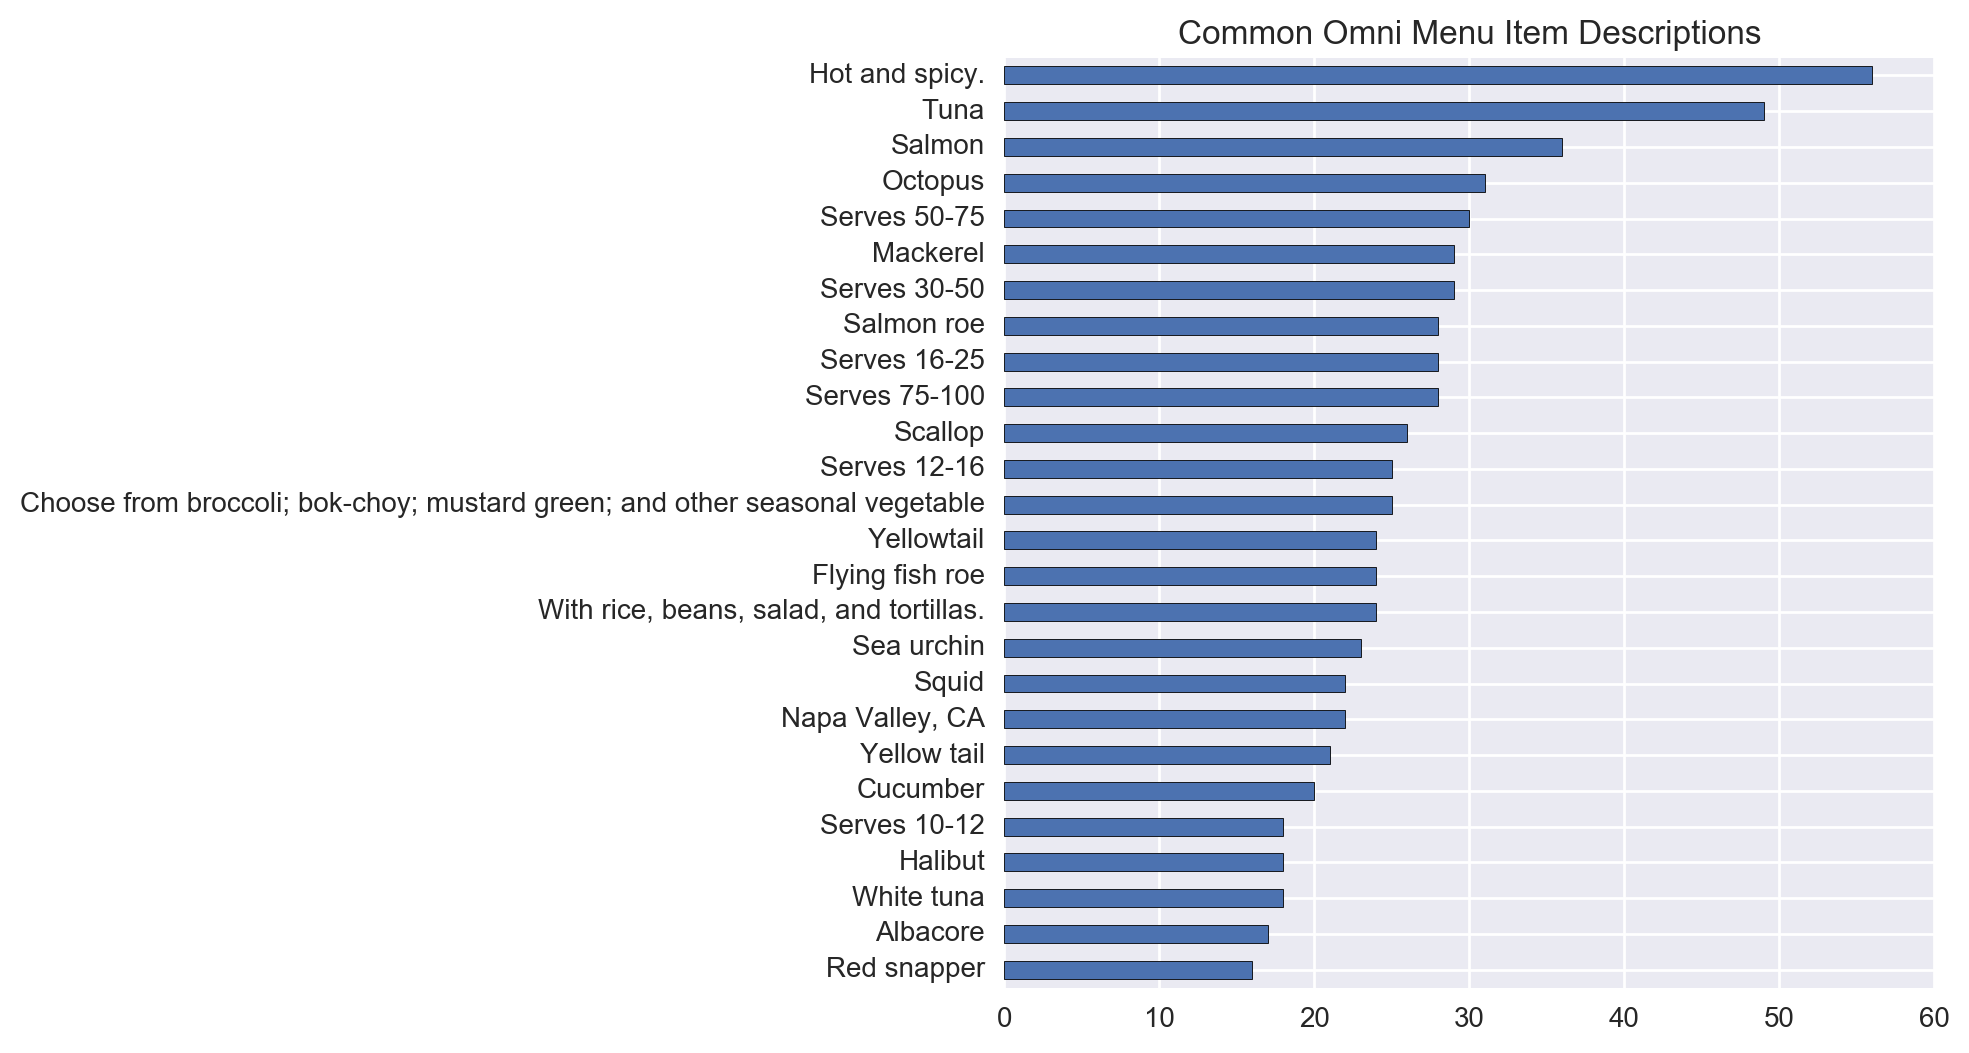

In [3]:
# Let's plot the most common item descriptions
desc_count = food[food.menu_item_desc != 'desc_not_available']
desc_count = desc_count[desc_count.groupby('menu_item_desc').menu_item_desc.transform(len) > 15]

plt.figure(figsize=(6,6))
desc_count['menu_item_desc'].value_counts().sort_values().plot(kind='barh')
plt.title('Common Omni Menu Item Descriptions')

If we contrast the above plot with just the vegan subset, we find that the most common menu item descriptions in vegan venues are distributed relatively evenly. However, it is important to mention that a few venues in each set of data are overrepresented. This comes as a result of those venues using the same descriptions for a variety of items on their respecitve menus.

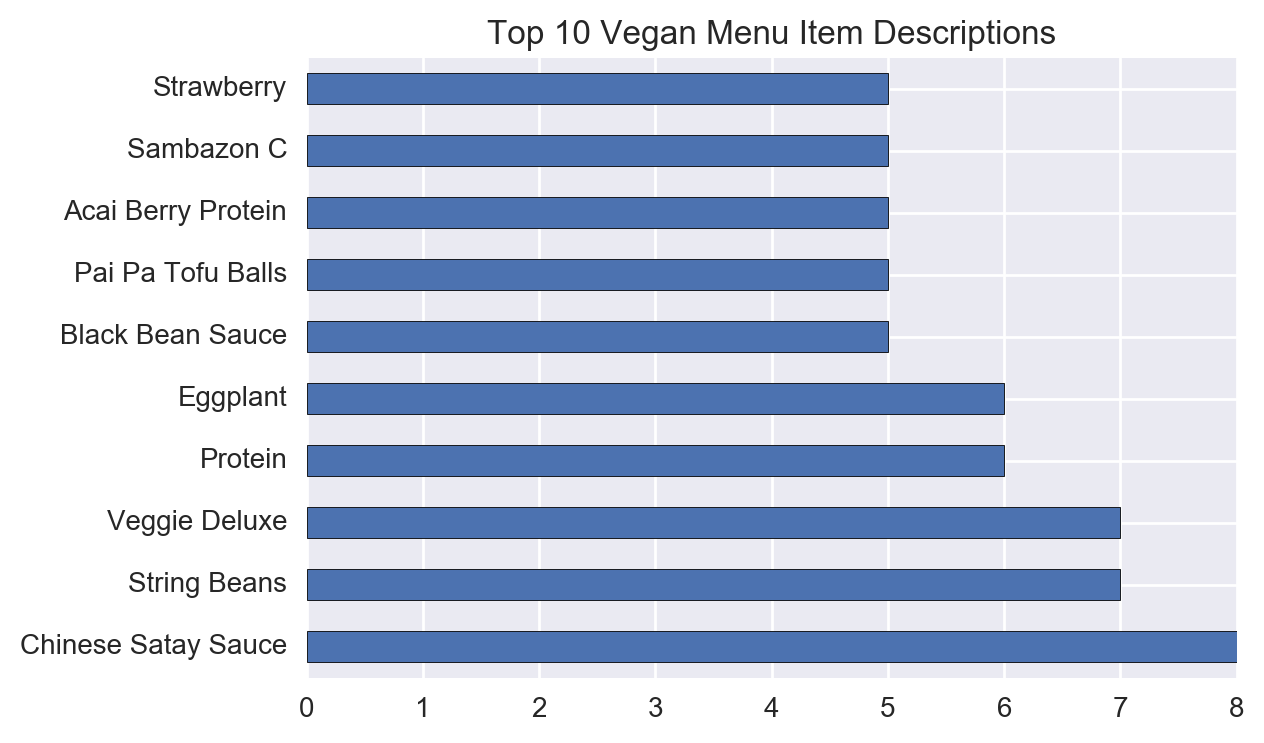

In [4]:
vegan_desc = vegan[vegan.menu_item_desc != 'desc_not_available']
vegan_desc = vegan_desc[vegan_desc.groupby('menu_item_desc').menu_item_desc.transform(len) > 0]
vegan_tops = vegan_desc.menu_item_name.value_counts()
vegan_tops = vegan_tops[:10]
vegan_tops.plot(kind='barh')

plt.title('Top %s Vegan Menu Item Descriptions' %len(vegan_tops))

## B. Item Names

Most commonly, we observe beverages and condiments as having relatively uniform naming conventions. Potentially notable standouts, though, include French Fries, Chicken Salad, Chicken Teriyaki, Salmon, Greek Salad, Green Salad and Tiramisu. This may reflect base traits that exist across a variety of menus, and furthermore, the palate of the San Franciscan who goes out to eat - in other words, the market is supplying these products at a higher rate, possibly because of pre-existing local preferences.

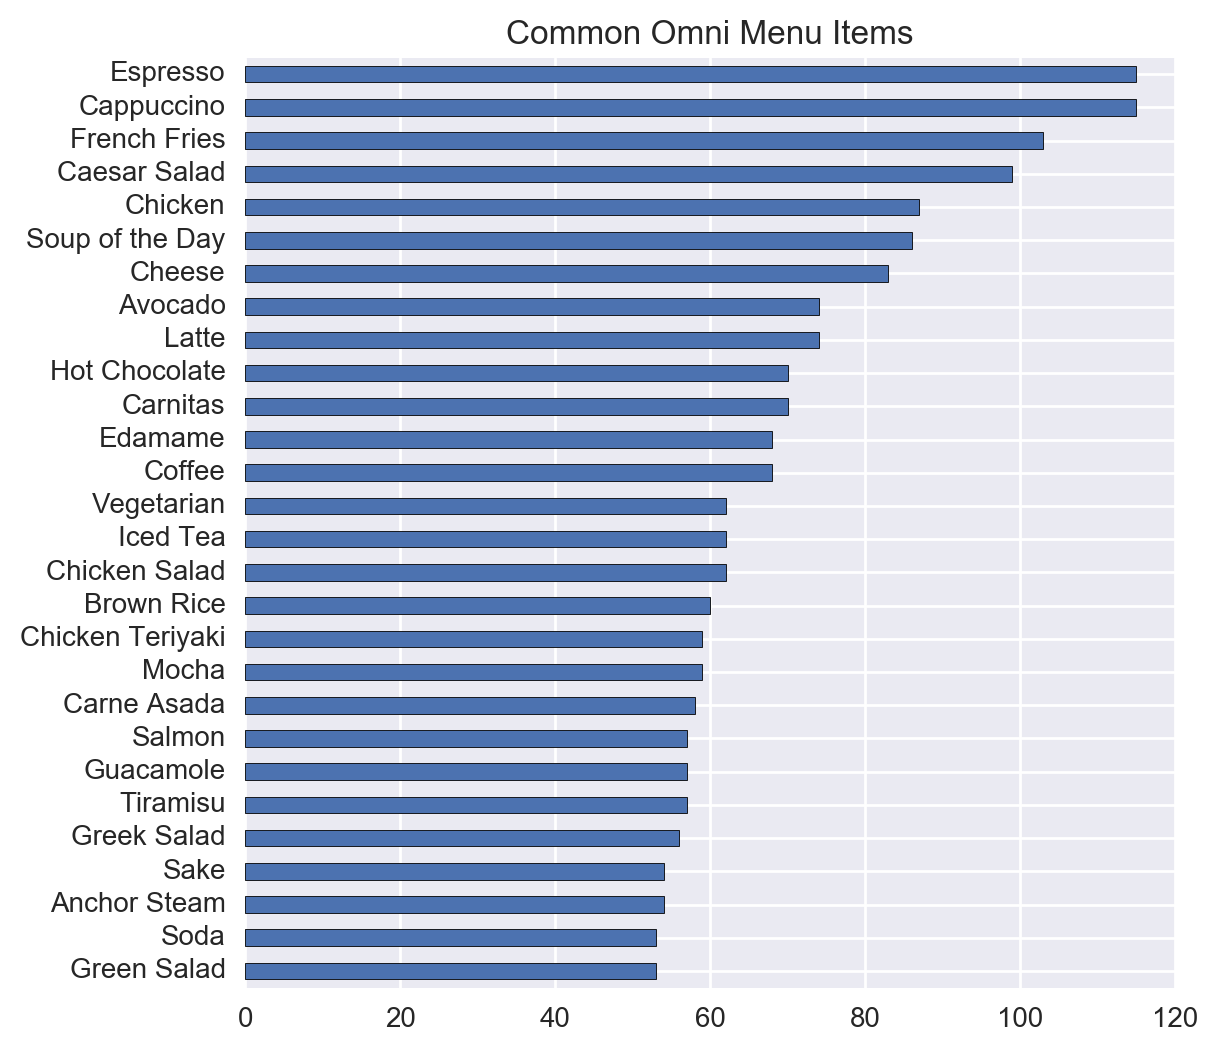

In [5]:
# Let's try the most common items
item_count = food[food.groupby('menu_item_name').menu_item_name.transform(len) > 50]
item_tops = item_count.menu_item_name.value_counts()

plt.figure(figsize=(6,6))
item_tops.sort_values().plot(kind='barh')
plt.title('Common Omni Menu Items')

In [6]:
# Out of curiosity, I'm going looking at the various descriptions under French Fries
food[food.menu_item_name == 'French Fries'].menu_item_desc.value_counts().head()

# Turns out that one French Fries dish is a whole lot like any other French Fries dish. Who would have thought?

desc_not_available                         80
Smoky ketchup, sweet-onion aioli            2
Smoky tomato ketchup, sweet-onion aioli     2
Anchovy Ketchup                             2
With aioli                                  2
Name: menu_item_desc, dtype: int64

Below I repeated the same analysis, but for the vegan subset. This basically indicates that unlike omni venues, vegan venues have very few menu items that can be found at different venues i.e. vegan venues tend to have unique menu items. This finding is similar to that which was given for the vegan item descriptions.

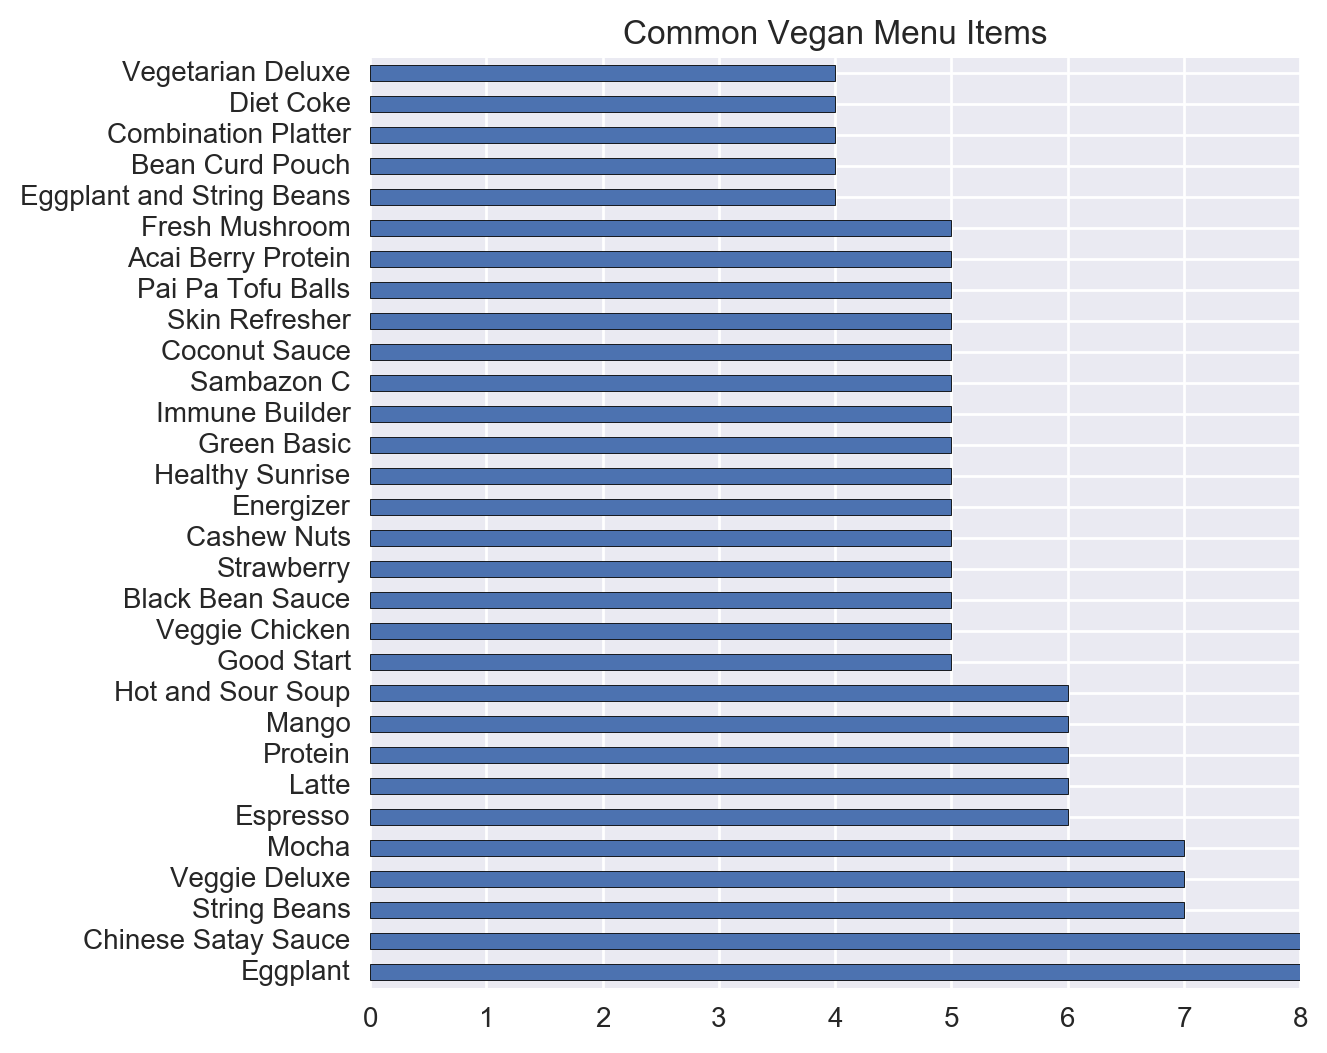

In [7]:
# Let's try the most common vegan items
item_count = vegan[vegan.groupby('menu_item_name').menu_item_name.transform(len) > 0]
vegan_tops = item_count.menu_item_name.value_counts()

plt.figure(figsize=(6,6))
vegan_tops[:30].plot(kind='barh')
plt.title('Common Vegan Menu Items')

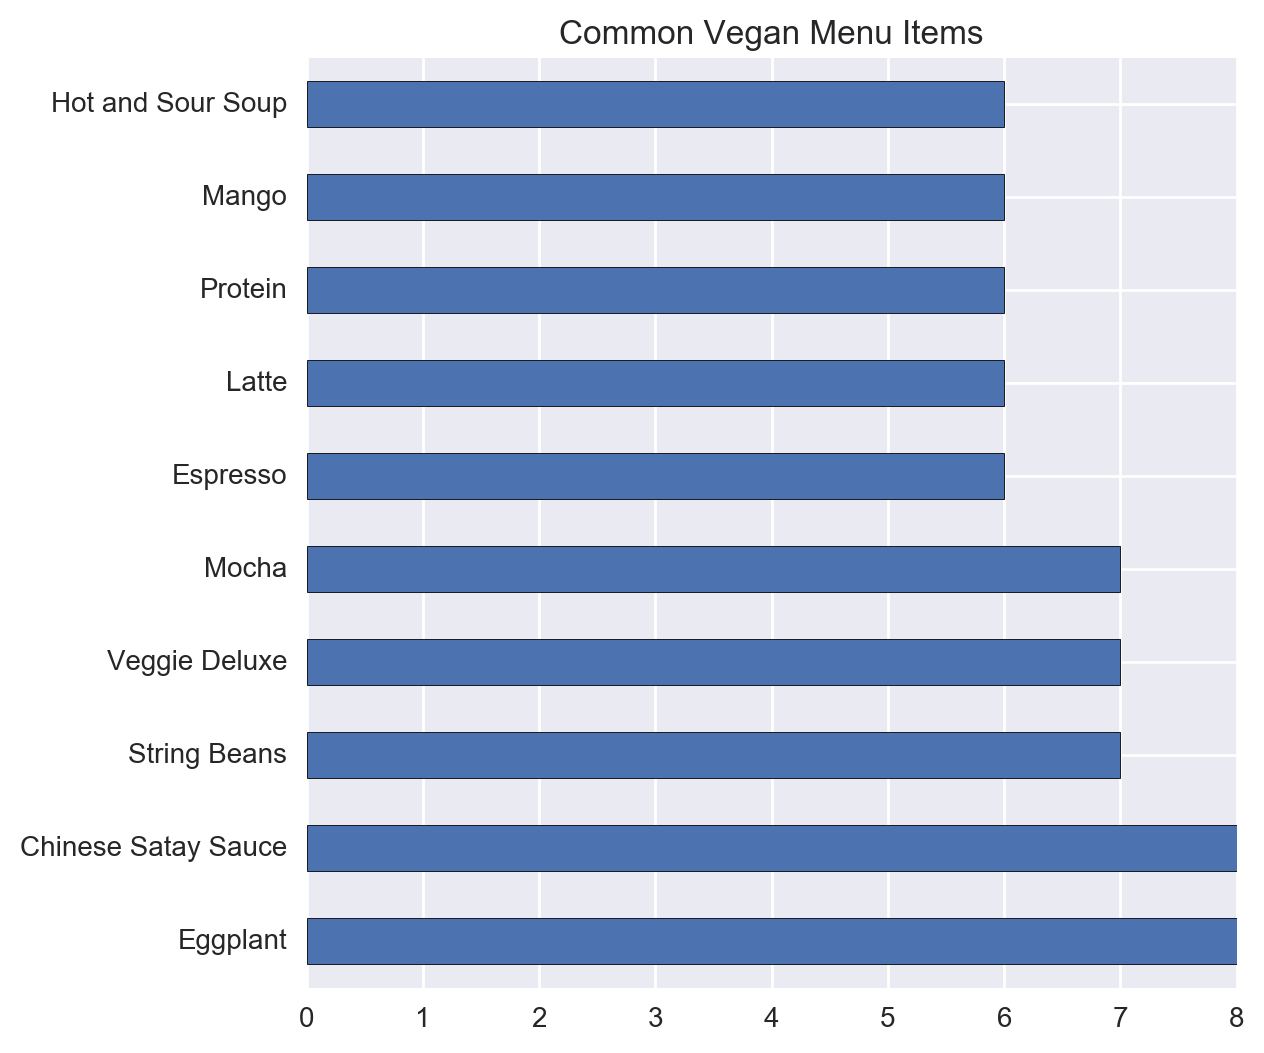

In [8]:
# Let's try the most common vegan items
item_count = vegan[vegan.groupby('menu_item_name').menu_item_name.transform(len) > 0]
vegan_tops = item_count.menu_item_name.value_counts()

plt.figure(figsize=(6,6))
vegan_tops[:10].plot(kind='barh')
plt.title('Common Vegan Menu Items')

## C. Item Pricing

I followed up by looking at the specific price points that venues were using. This means that though $12 was the most common price point, $11.95 shows up separately as another common price point. For that reason, I made an easy-to-use widget below that allows a user to input a range of prices, and learn
    - 1) how many items in my dataset fit in that range, inclusively
    - 2) an approximate percentage of how many items fit in that range, inclusively
    - 3) an approximate percentage of how many unique items fit in that range, inclusively
It is also notable how while there is a slight skew for the exact price point data, on whole, pricing is distributed across a wide range.

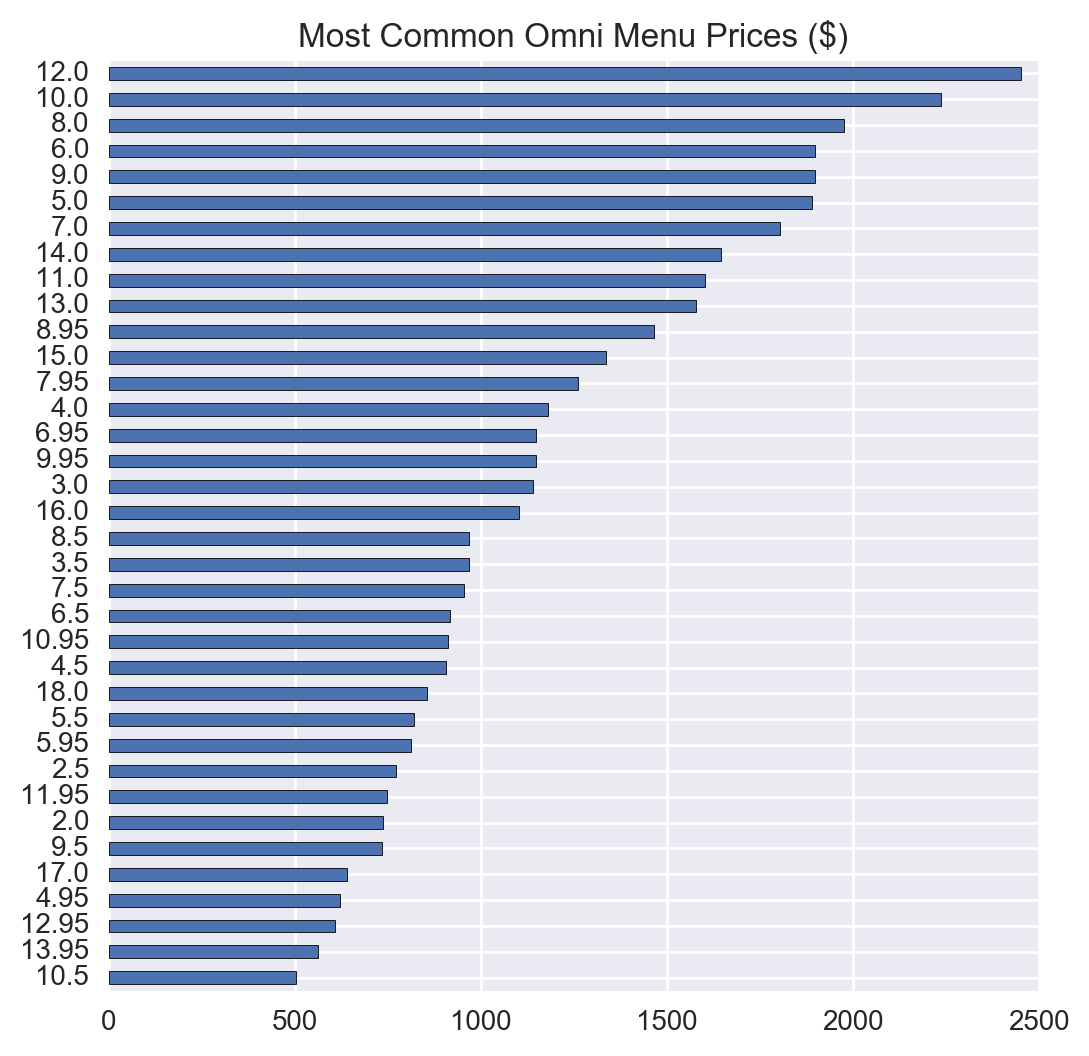

In [9]:
# Let's try the most common item prices
item_price = food[food.groupby('menu_item_price').menu_item_price.transform(len) > 500]
item_price = item_price[item_price.menu_item_price != 'price_not_available']
item_price.menu_item_price.value_counts()

plt.figure(figsize=(6,6))
item_price['menu_item_price'].value_counts().sort_values().plot(kind='barh')
plt.title('Most Common Omni Menu Prices ($)')

In [10]:
has_price = food[food.menu_item_price != 'price_not_available']
# lower_bound = 11.49
# upper_bound = 12.49
def price_range(lower_bound, upper_bound):
    common_omni = has_price[has_price.menu_item_price >= lower_bound][has_price.menu_item_price <= upper_bound]
    print "Items in the $%.2f-$%.2f range:" % (lower_bound, upper_bound), common_omni.shape[0]
def percentage_in_range(lower_bound, upper_bound):
    common_omni = has_price[has_price.menu_item_price >= lower_bound][has_price.menu_item_price <= upper_bound]
    percents = float(len(common_omni.menu_item_name))/ len(has_price.menu_item_name) * 100.
    print "Approx percentage of items in $%.2f-$%.2f range:" % (lower_bound, upper_bound), round(percents)
def unique_percentage_in_range(lower_bound, upper_bound):
    common_omni = has_price[has_price.menu_item_price >= lower_bound][has_price.menu_item_price <= upper_bound]
    print "Approx percentage of unique items in the $%.2f-$%.2f range:" %(lower_bound, upper_bound), \
round(float(len(common_omni.menu_item_name.unique()))/len(has_price.menu_item_name.unique())*100)

In [11]:
lower_bound = widgets.Text(description="Lower Bound:", placeholder="Enter a low price!")
upper_bound = widgets.Text(description="Higher Bound:", placeholder="Enter a high price!")

my_button = widgets.Button(description="This better be good...")

def on_submit(ui):

    item_count = price_range(float(lower_bound.value), float(upper_bound.value))
    percents = percentage_in_range(float(lower_bound.value), float(upper_bound.value))
    percent_counts = unique_percentage_in_range(float(lower_bound.value), float(upper_bound.value))
    return item_count, percents, percent_counts

my_button.on_click(on_submit)

display(lower_bound)
display(upper_bound)
display(my_button)

A histogram of the data somewhat confirms the sense that menu price points are distributed across a range. But, we can also surface the approximate median, which is just under the $10$ mark. The mean would be out above $30$, indicating a strong right skew.

*Note: I have only included that prices with at least 300 data points in the graph. However, the median is based on all the available pricing data.*

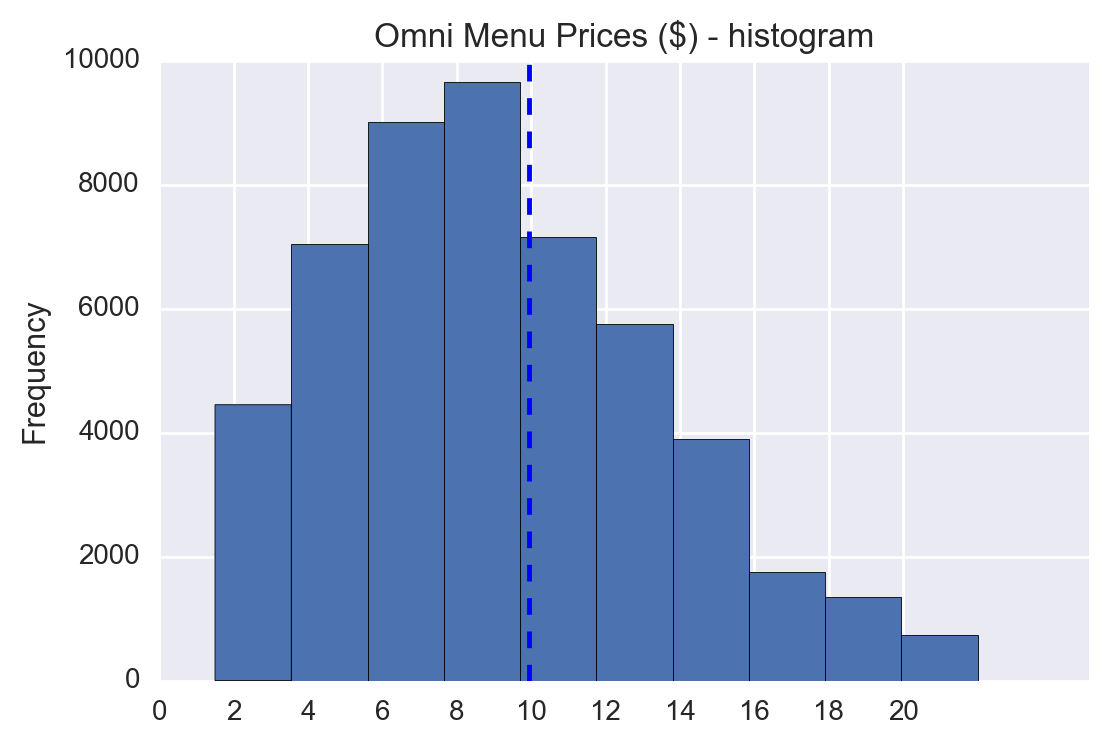

In [12]:
# Histogram of the same data, menu item prices - note how this is only including frequencies > 300
item_price = food[food.groupby('menu_item_price').menu_item_price.transform(len) > 300]
item_price = item_price[item_price.menu_item_price != 'price_not_available']
item_price.menu_item_price.value_counts()

item_price.menu_item_price.sort_values().plot(kind='hist', xticks=range(0,21,2))
plt.axvline(x = has_price['menu_item_price'].median(), linestyle='dashed')
plt.title('Omni Menu Prices ($) - histogram')

Shifting gears again to the vegan subset, we actually see that the most common price drops down to $8.50$, from the previous $12$ price mode inclusive of all venues. I also included another interactive widget to further explore price points.

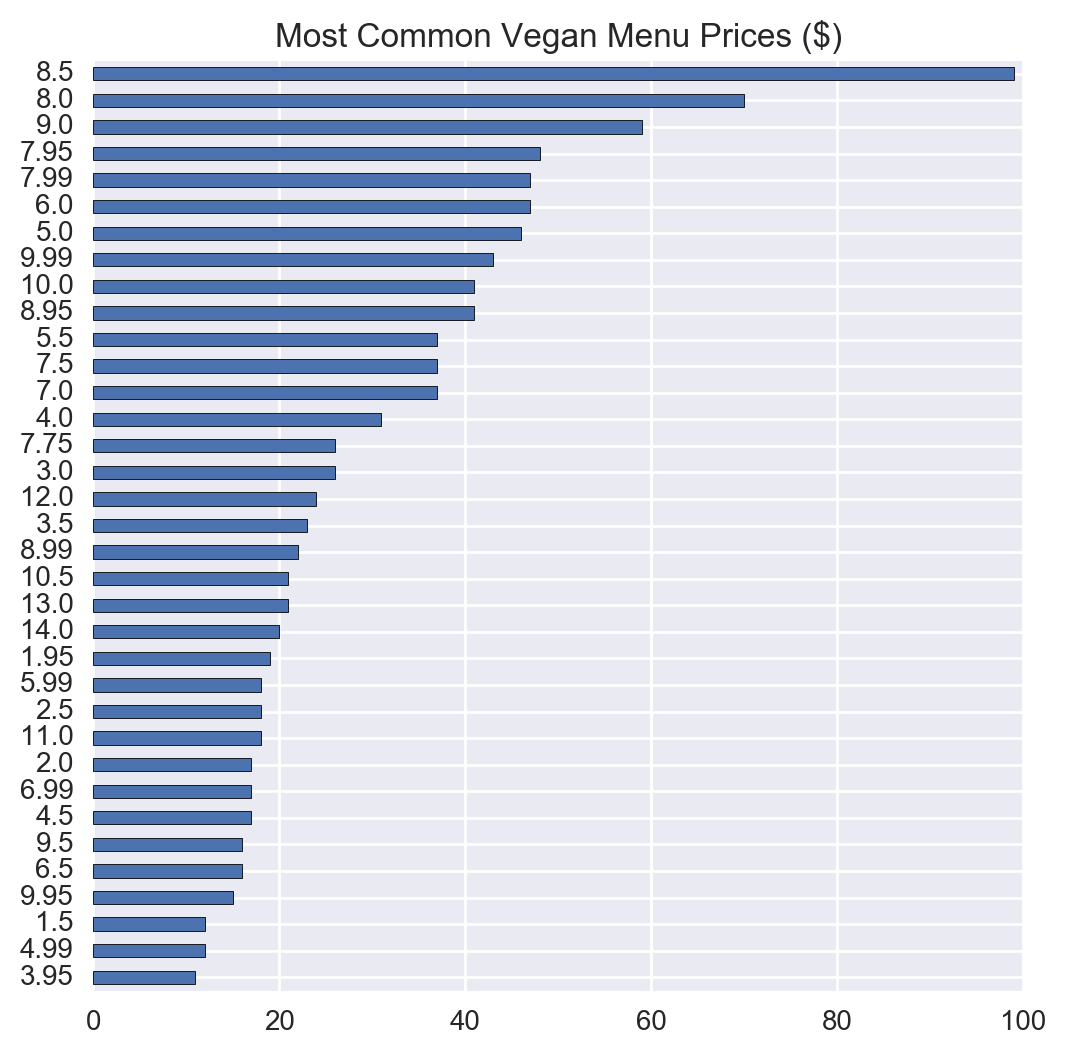

In [13]:
vegan_price = vegan[vegan.groupby('menu_item_price').menu_item_price.transform(len) > 10]
vegan_price = vegan_price[vegan_price.menu_item_price != 'price_not_available']
vegan_price.menu_item_price.value_counts()

plt.figure(figsize=(6,6))
vegan_price['menu_item_price'].value_counts().sort_values().plot(kind='barh')
plt.title('Most Common Vegan Menu Prices ($)')

In [14]:
has_price = vegan[vegan.menu_item_price != 'price_not_available']
# lower_bound = 11.49
# upper_bound = 12.49
def price_range(lower_bound, upper_bound):
    common_omni = has_price[has_price.menu_item_price >= lower_bound][has_price.menu_item_price <= upper_bound]
    print "Items in the $%.2f-$%.2f range:" % (lower_bound, upper_bound), common_omni.shape[0]
def percentage_in_range(lower_bound, upper_bound):
    common_omni = has_price[has_price.menu_item_price >= lower_bound][has_price.menu_item_price <= upper_bound]
    percents = float(len(common_omni.menu_item_name))/ len(has_price.menu_item_name) * 100.
    print "Approx percentage of items in $%.2f-$%.2f range:" % (lower_bound, upper_bound), round(percents)
def unique_percentage_in_range(lower_bound, upper_bound):
    common_omni = has_price[has_price.menu_item_price >= lower_bound][has_price.menu_item_price <= upper_bound]
    print "Approx percentage of unique items in the $%.2f-$%.2f range:" %(lower_bound, upper_bound), \
round(float(len(common_omni.menu_item_name.unique()))/len(has_price.menu_item_name.unique())*100)

In [15]:
lower_bound = widgets.Text(description="Lower Bound:", placeholder="Enter a low price!")
upper_bound = widgets.Text(description="Higher Bound:", placeholder="Enter a high price!")

my_button = widgets.Button(description="This best be good...")

def on_submit(ui):

    item_count = price_range(float(lower_bound.value), float(upper_bound.value))
    percents = percentage_in_range(float(lower_bound.value), float(upper_bound.value))
    percent_counts = unique_percentage_in_range(float(lower_bound.value), float(upper_bound.value))
    return item_count, percents, percent_counts

my_button.on_click(on_submit)

display(lower_bound)
display(upper_bound)
display(my_button)

The histogram of the vegan subset is much more normally distributed, with the median (at exactly $8$) holding inside the mode range of prices.

*Note: I have only included that prices with at least 3 data points in the graph.*

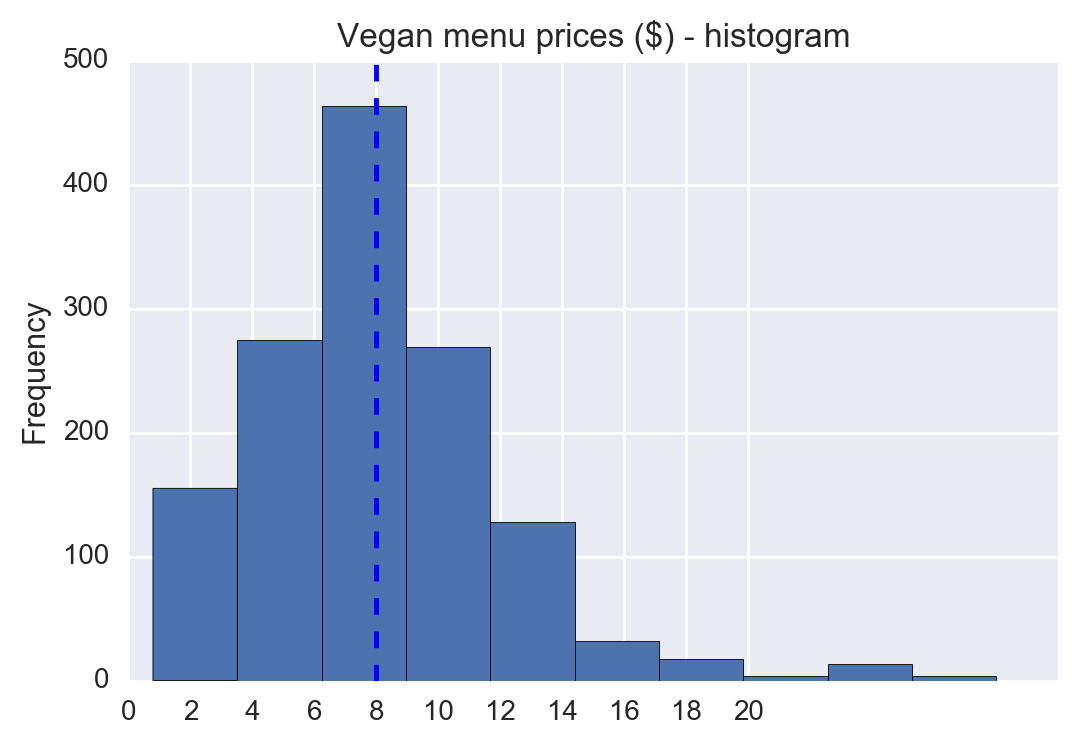

In [16]:
vegan_price = vegan[vegan.groupby('menu_item_price').menu_item_price.transform(len) > 3]
vegan_price = vegan_price[vegan_price.menu_item_price != 'price_not_available']
vegan_price.menu_item_price.value_counts()

vegan_price.menu_item_price.sort_values().plot(kind='hist', xticks=range(0,21,2))
plt.axvline(x = vegan_price.menu_item_price.median(), linestyle='dashed')
plt.title('Vegan menu prices ($) - histogram')

# This histogram result is very interesting, particularly when compared to the Omni

## D. Venue Ratings

For omni venues, we can see that there are also a few specific ratings which happen to be the most common, namely those at 8.4, and 8.6 out of 10. In fact, out of the top ten most common overall venue ratings, eight are ratings between 8 and 9, inclusive. The total range, as observable in the histogram, is approximately between 5.5 and 9.5, with a slight left skew. The mean and median are both almost exactly 8.2 out of 10 (the median is again represented by the dashed line), indicating that on whole, the ratings are relatively normally distributed. This is interesting insofar that it demonstrates a certain level of fairness to the ratings that individual venues may receive from the Foursquare user base.

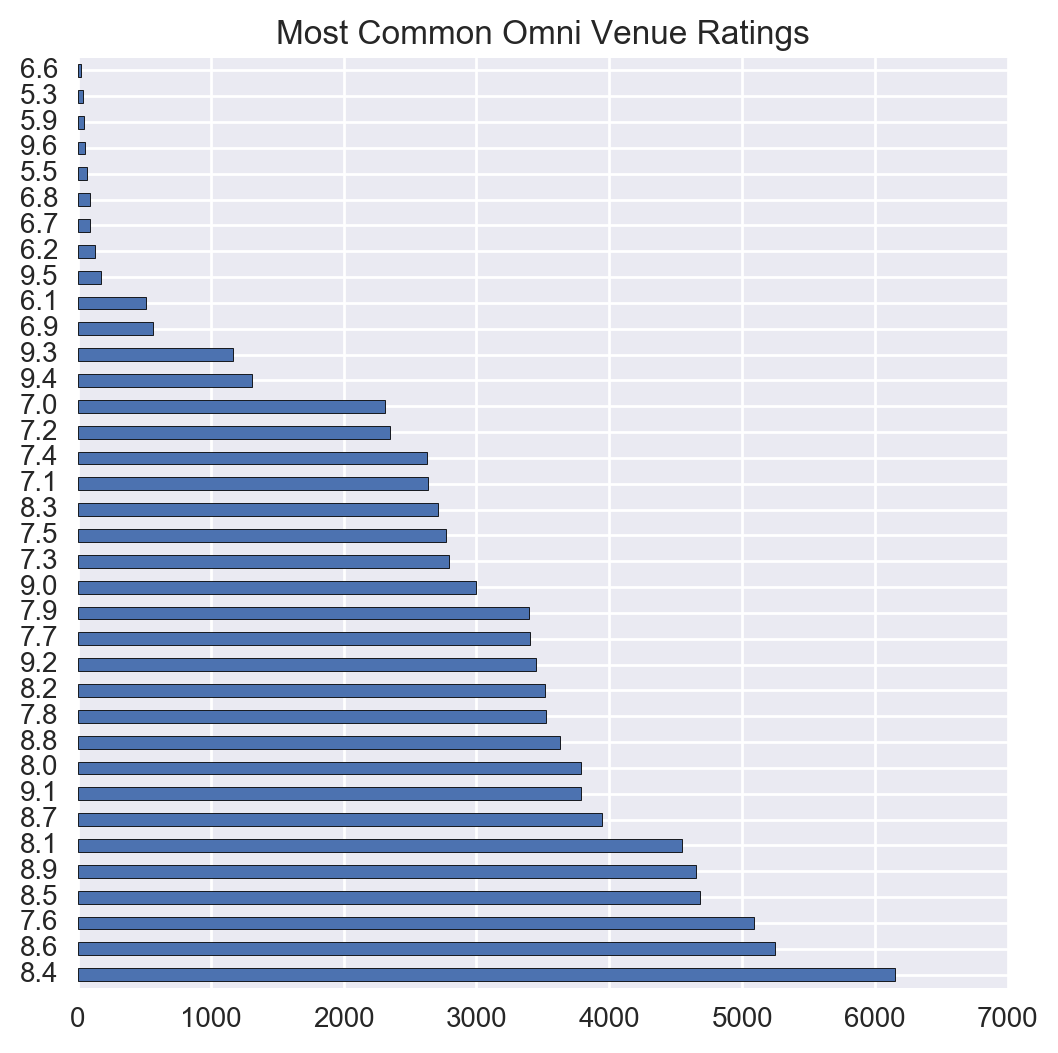

In [17]:
# Let's try looking at venue ratings
venue_rating = food[food.groupby('venue_rated').venue_rated.transform(len) > 0]
venue_rating = venue_rating[venue_rating.venue_rated != 'rating_not_available']
venue_rating.venue_rated.value_counts()

plt.figure(figsize=(6,6))
venue_rating.venue_rated.value_counts().plot(kind='barh')
plt.title('Most Common Omni Venue Ratings')

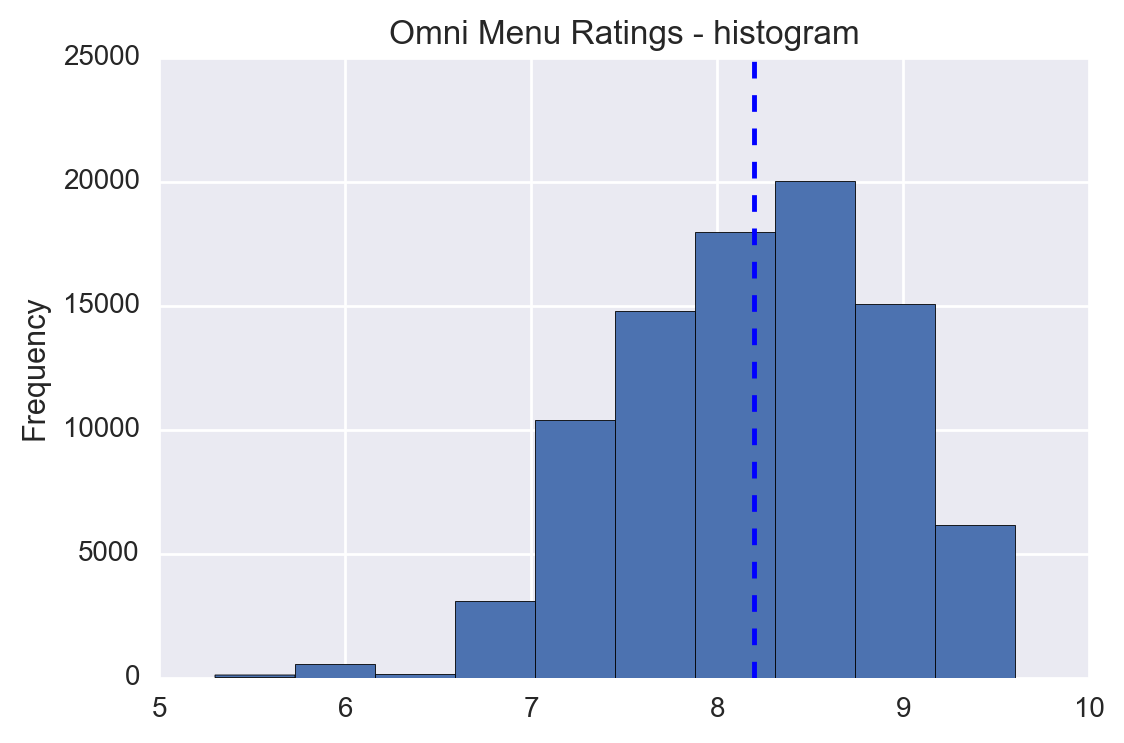

In [18]:
venue_rating = food[food.groupby('venue_rated').venue_rated.transform(len) > 0]
venue_rating = venue_rating[venue_rating.venue_rated != 'rating_not_available']
venue_rating.venue_rated.value_counts()

venue_rating.venue_rated.sort_values().plot(kind='hist')
plt.axvline(x = food[food.venue_rated != 'rating_not_available'].venue_rated.median(), linestyle='dashed')
plt.title('Omni Menu Ratings - histogram')

Looking at common vegan ratings, over 600 ratings (or about 30% of vegan venues) are 7.9 or 8.1. While this average is relatively close to that given for omni venues, the distribution of ratings is certainly not normally distributed, and generally far less stable. It appears that vegan venues, at least according to the ratings, tend to be 'hit-or-miss,' whereas the ratings (and thus perhaps quality) of omni venues coalesces to a particular mean.

The vegan histogram in this case reveals a significant behavioral difference between the way Foursquare users rate omni venues versus vegan venues - namely that the standard for vegan venues is a bit higher. This may stem from the strict requisites that a vegan patron may have, compared to an omni patron. But it is conversely interesting to see that the range of ratings is also significantly tighter (from 7.4 to 9.0, compared to the 5.3 to 9.6 range that omni venues enjoy). So perhaps vegan patrons are less likely to give a more extreme rating than their omni counterparts.

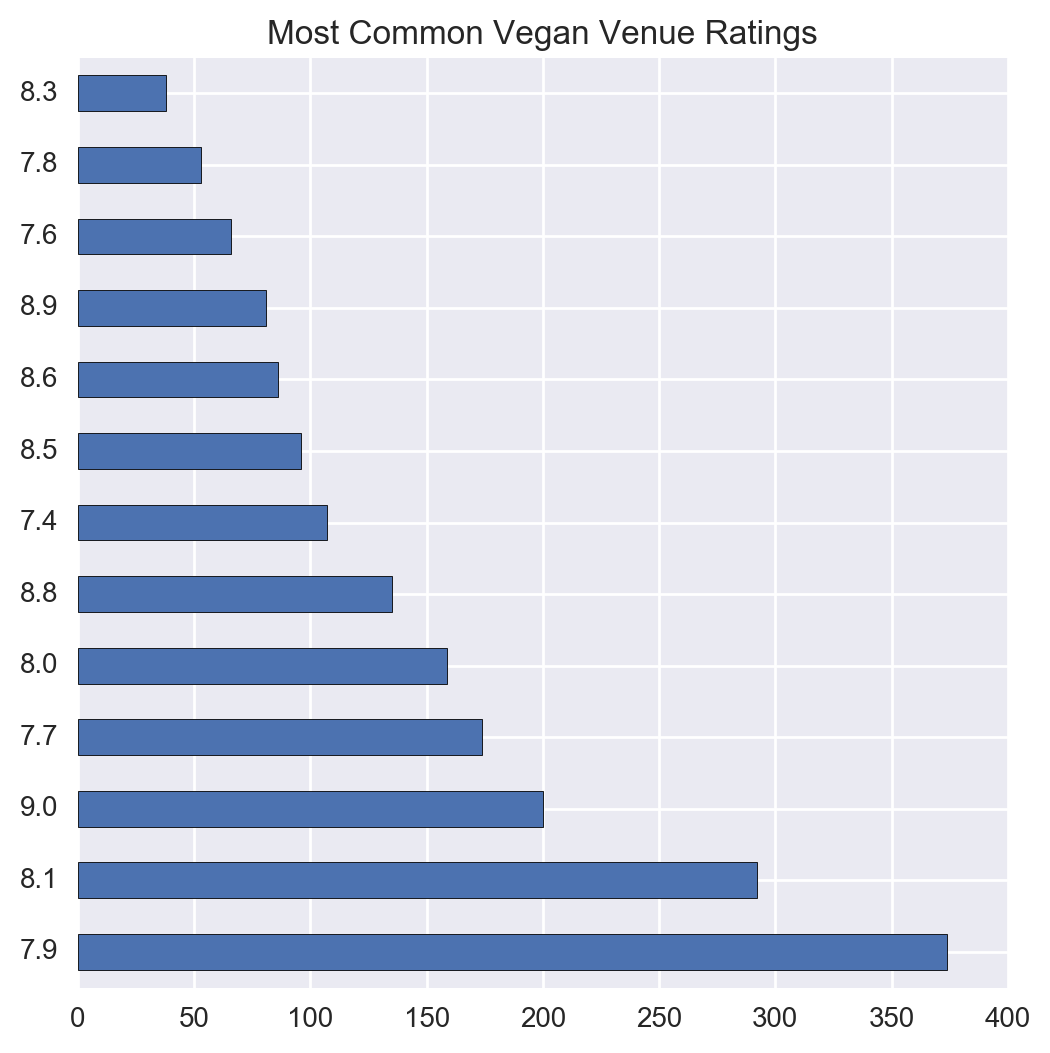

In [19]:
# Let's try looking at the vegan venue ratings
venue_rating = vegan[vegan.groupby('venue_rated').venue_rated.transform(len) > 0]
venue_rating = venue_rating[venue_rating.venue_rated != 'rating_not_available']
venue_rating.venue_rated.value_counts()

plt.figure(figsize=(6,6))
venue_rating.venue_rated.value_counts().plot(kind='barh')
plt.title('Most Common Vegan Venue Ratings')

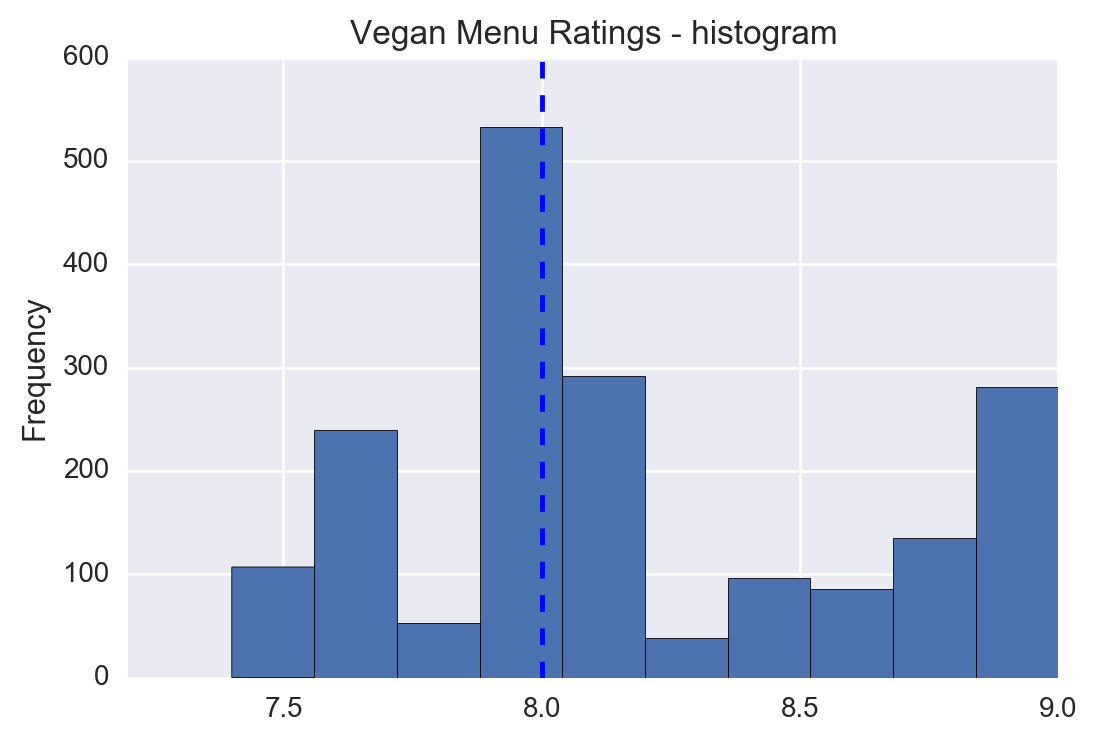

In [20]:
venue_rating = vegan[vegan.groupby('venue_rated').venue_rated.transform(len) > 0]
venue_rating = venue_rating[venue_rating.venue_rated != 'rating_not_available']
venue_rating.venue_rated.value_counts()

venue_rating.venue_rated.sort_values().plot(kind='hist')
plt.axvline(x = vegan[vegan.venue_rated != 'rating_not_available'].venue_rated.median(), linestyle='dashed')
plt.title('Vegan Menu Ratings - histogram')

## E. Venue Categories

Before I get into the details around venue categories, it's important to keep in mind that many venues (over 51% in fact) have multiple venue categories. Therefore, the number of categories represented significantly outpaces the number of unique venues. Having said that, American and Italian are by far the most popular specific categories for restaurants to be in, followed by a diverse group of Asian categories (ranging from Chinese and Japanese, to Thai and Vietnamese). Out of the the top 20 categories, six are explicitly Asian, and three more have some other foreign ethnic affiliation. Still, it's also worth pointing out that there is a significant long-tail of data, as evidenced by how only about 2% of venues even identify as belonging to either of the top two categories.

In the vegan realm, the most common venue category by far is Vegetarian/Vegan categorization, because this was how I originally identified which food items would automatically be batched as vegan. So, I removed that outlier from my graph. Unlike omni vegan categories however, over 58% of vegan venues hold one or more of the next top three most common categorizations - namely Chinese Restaurant, Salad Place, and Cafe. And out of the subsequent top 14 categories, eight have a foreign ethnic affiliation. This trait is on its face more in line with its omni counterpart. However, recalling the level of concentration of categorization that exists for vegan venues, we can say confidently that vegan venues are far more likely to have an ethnic affiliation. Interestingly, this evidence corroborates my previous suspicions based on anecdotal experience. As a consequence, I worry that the quantity of ethnic foods represented in the vegan subset will make a natural language approach less effective - natural language analyses work best in the lingua franca.

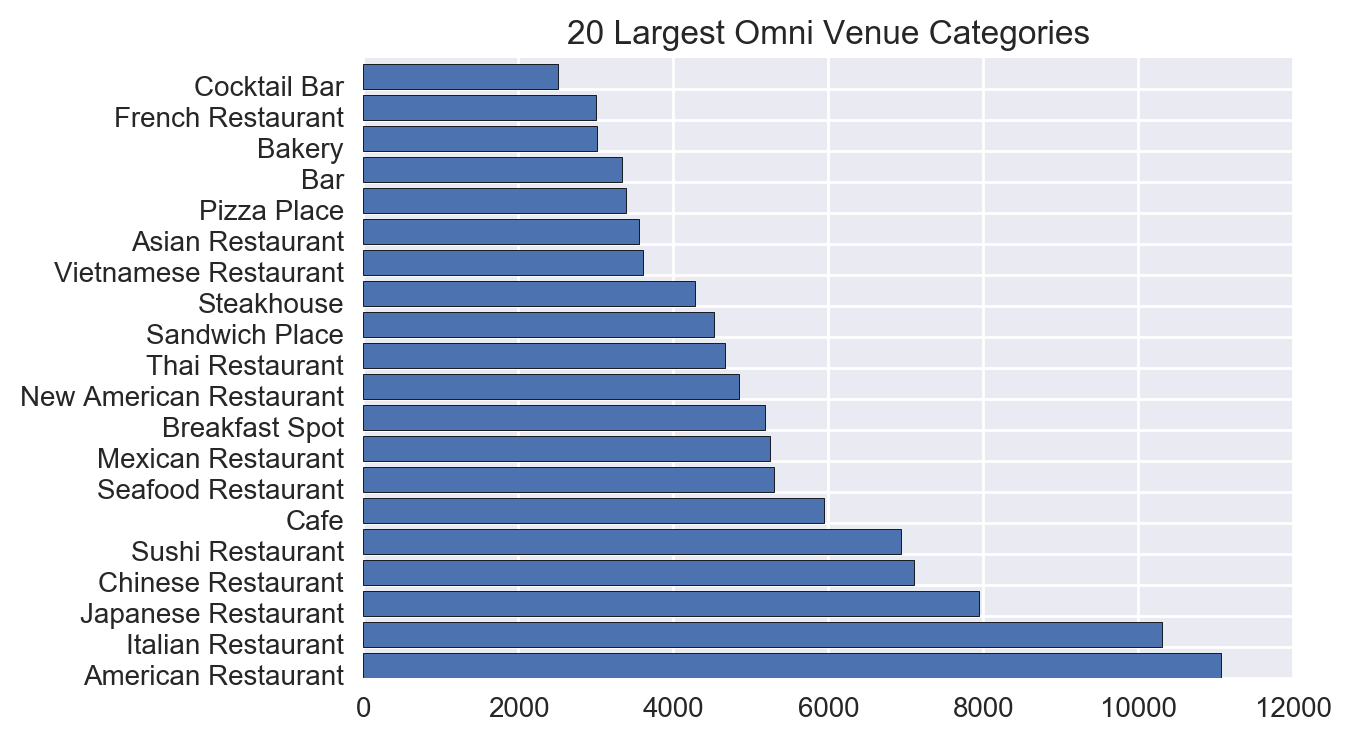

In [21]:
pop_venue_desc = [each_desc for desc_list in food.venue_desc_list for each_desc in desc_list]
pop_venues = Counter(pop_venue_desc).most_common()
pop_venues = pop_venues[:20]

fig, ax = plt.subplots()
ax.barh(range(len(pop_venues)), [counts[1] for counts in pop_venues])
ax.set_yticks(range(len(pop_venues)))
ax.set_yticklabels([counts[0] for counts in pop_venues])
ax.set_title('%s Largest Omni Venue Categories' %str(len(pop_venues))) 
plt.show()

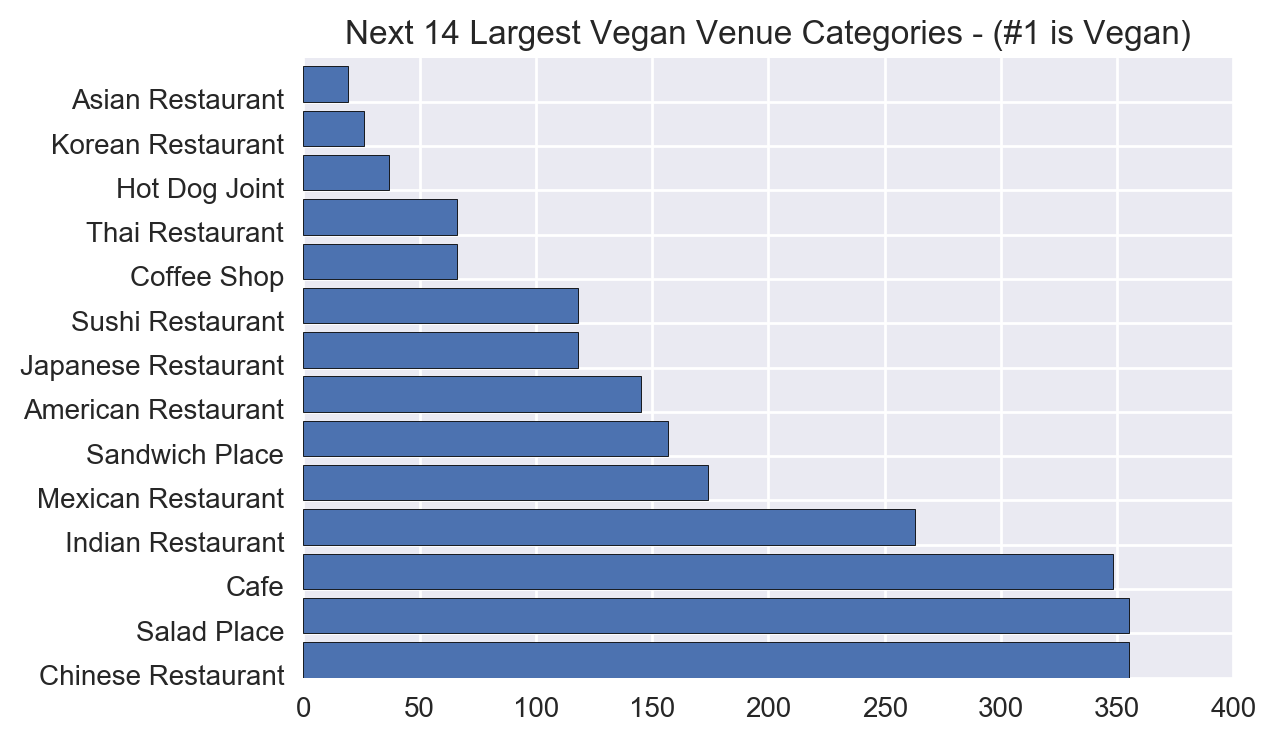

In [22]:
pop_venue_desc = [each_desc for desc_list in vegan.venue_desc_list for each_desc in desc_list]
pop_venues = Counter(pop_venue_desc).most_common()
pop_venues = pop_venues[1:15]

fig, ax = plt.subplots()
ax.barh(range(len(pop_venues)), [counts[1] for counts in pop_venues])
ax.set_yticks(range(len(pop_venues)))
ax.set_yticklabels([counts[0] for counts in pop_venues])
ax.set_title('Next %s Largest Vegan Venue Categories - (#1 is Vegan)' %str(len(pop_venues))) 
plt.show()

## F. Menus

Almost every menu had two particular menu types within the entire menu, which formed the heirarchy of products that could be served. I chose to refer to these two menu types as, respectively, the meta-menu and the sub-menu. Though the first several popular names are fairly typical examples of standardization, there is some differentiation as far as restaurants that have beverage/wine menus, and those that do not. A similar trend can be seen in the vegan subset, where again lunch and dinner designations tend to be most popular.

Because the variety of sub-menus was nearly non-existent for the vegan subset, I chose only to look at the omni subset. The most typical sub-menus by far can be thought of as 'starters,' where for example Appetizers, Sides and Salads reside. Perhaps the next most important commonality is the drink submenu, whether that be in reference to general Beverages, or specific drinks and alcohols. Other than that, I chose to explore what I considered to be a few unique sub-menu names - Appetizers, Pasta, and Nigiri. The Appetizers submenu appeared on 228 unique venues, or almost 25% of venues, which shows how truly important that submenu is for almost any venue. Pasta appeared as a submenu in 49 unique venues, and Antipasti appeared on 48 - likely an indication of the prominence of Italian restaurants and food preferences. And finally, 15 venues had submenus dedicated entirely to Nigiri, which I thought interesting given, again, how specific that category is for a particular ethnic category. In fact, just 17 restaurants of my entire dataset are vegan, which truly puts into perspective both the relative popularity of sushi, and the relative obscurity of vegan food, and the relative immaturity of the vegan venue market as a whole.

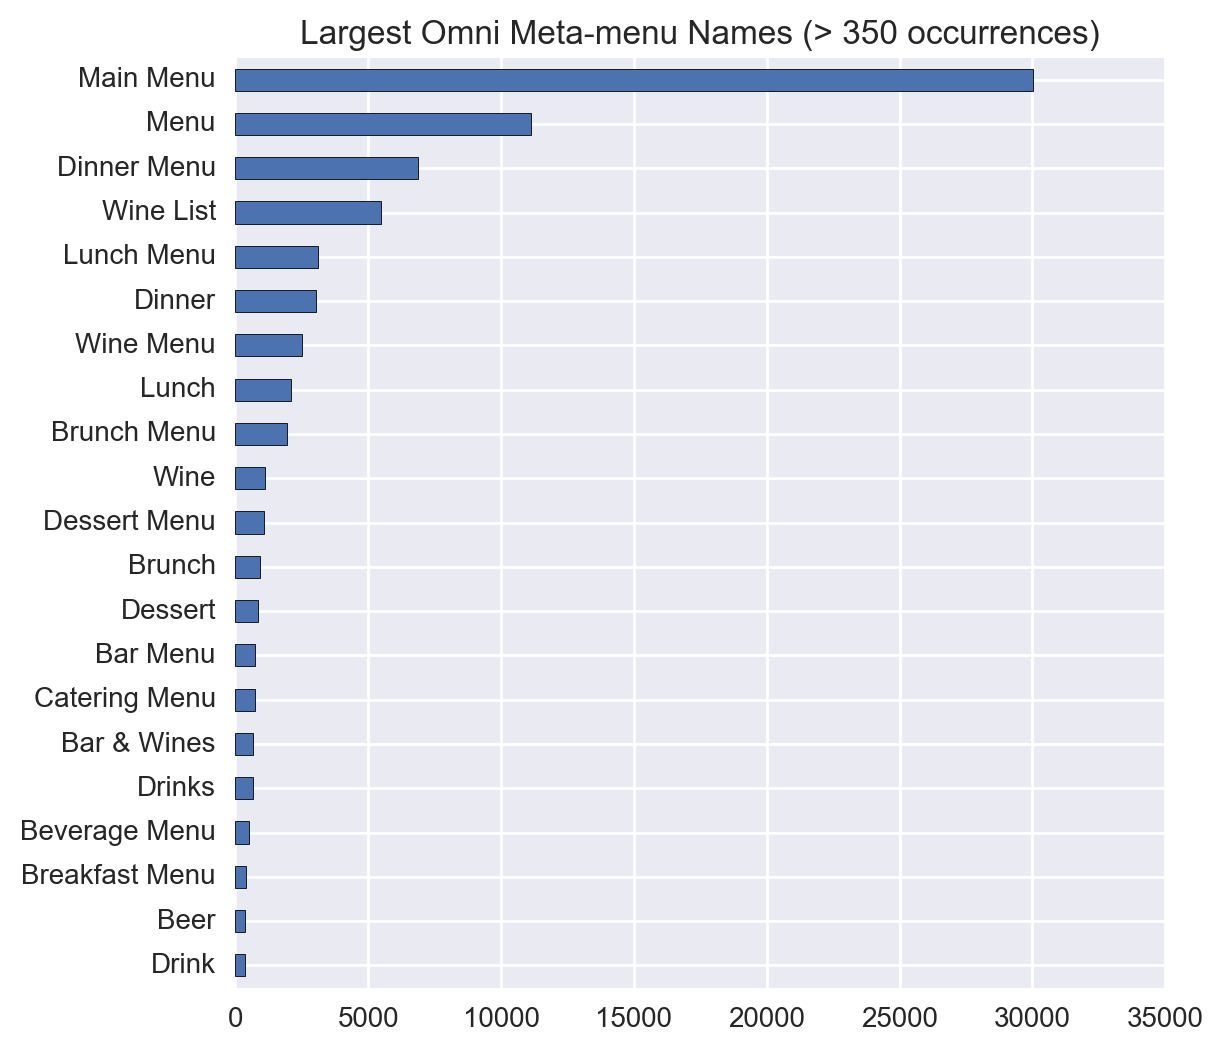

In [23]:
# Let's try the most common meta menu names
lim = 350
mmenu_count = food[food.groupby('meta_menu_n').meta_menu_n.transform(len) > lim]
mmenu_count.meta_menu_n.value_counts()

plt.figure(figsize=(6,6))
mmenu_count['meta_menu_n'].value_counts().sort_values().plot(kind='barh')
plt.title('Largest Omni Meta-menu Names (> %d occurrences)' %lim)

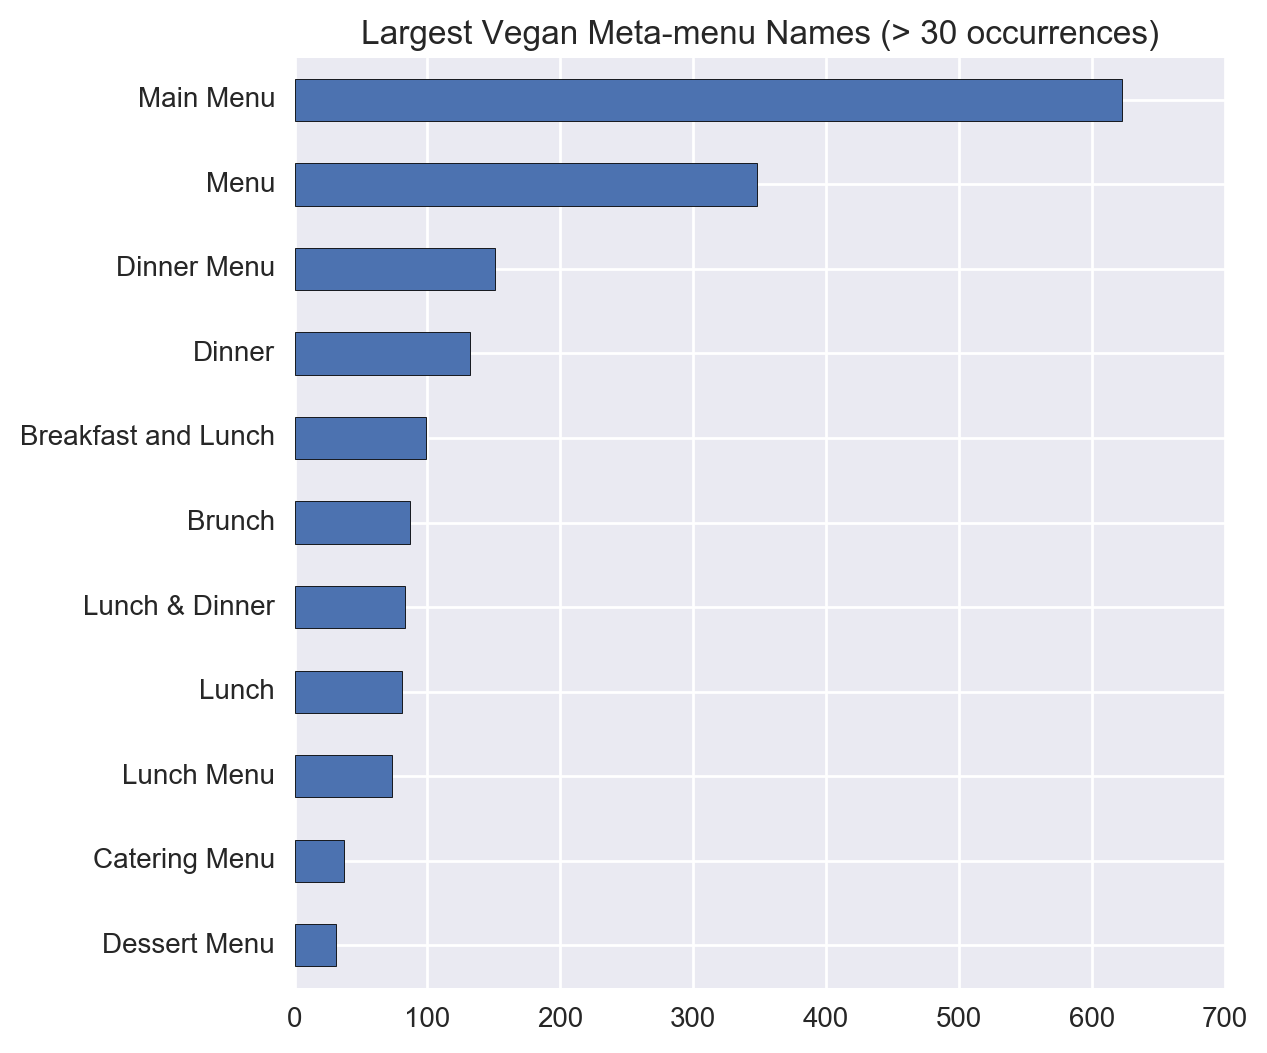

In [24]:
# Vegan meta-menu names
lim = 30
mmenu_count = vegan[vegan.groupby('meta_menu_n').meta_menu_n.transform(len) > lim]
mmenu_count.meta_menu_n.value_counts()

plt.figure(figsize=(6,6))
mmenu_count['meta_menu_n'].value_counts().sort_values().plot(kind='barh')
plt.title('Largest Vegan Meta-menu Names (> %d occurrences)' %lim)

Venues w/ the Appetizers submenu: 228
Venues w/ the Pasta submenu: 49
Venues w/ the Nigiri Sushi submenu: 15
Note: Largest vegan categories are too small to hold deductively reasoned value


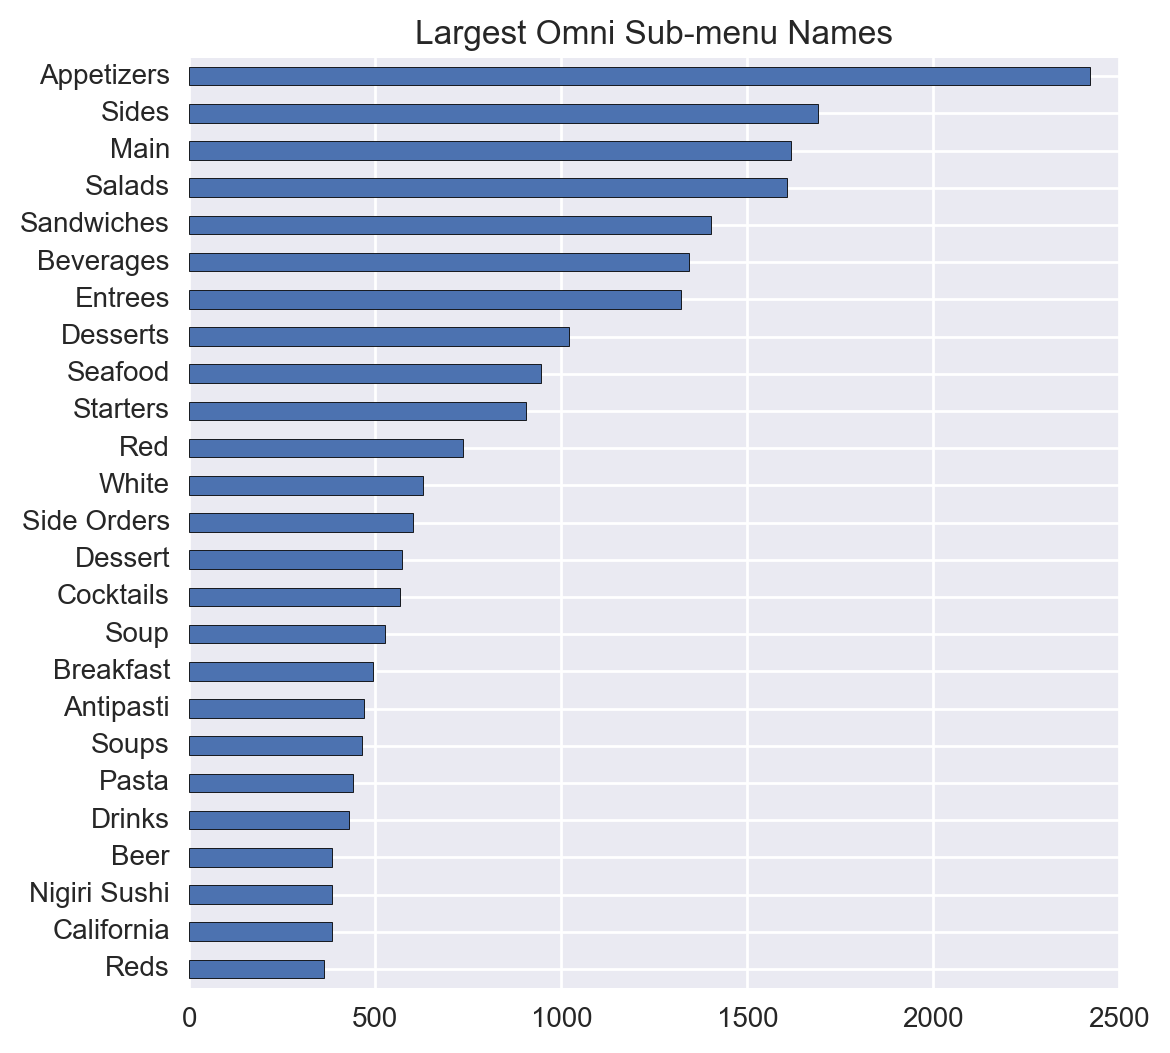

In [25]:
# Let's try the most common sub menu names
smenu_count = food[food.groupby('depth_menus_n').depth_menus_n.transform(len) > 350]
smenu_count.depth_menus_n.value_counts()

plt.figure(figsize=(6,6))
smenu_count['depth_menus_n'].value_counts().sort_values().plot(kind='barh')
plt.title('Largest Omni Sub-menu Names')

# Most commonly, and unsurprisingly, we see a breakdown between starters, entrees, and desserts. We can note
# how steep the logarithmic appearance of the graph is, indicating the dominance of a handful of submenu titles.
app = food[food.depth_menus_n == 'Appetizers']
print 'Venues w/ the Appetizers submenu:', len(app.venue_name.unique())

# We also see beverages and drinks. It's also interesting to see how pasta has broken in.
pasta = food[food.depth_menus_n == 'Pasta']
print 'Venues w/ the Pasta submenu:', len(pasta.venue_name.value_counts())

# I was also interested to see nigiri come in, and originally concluded there was just a couple venues
# being overrepresented. However looking below, this is actually not the case.
nigiri = food[food.depth_menus_n == 'Nigiri Sushi']
print 'Venues w/ the Nigiri Sushi submenu:', len(nigiri.venue_name.value_counts())
print 'Note: Largest vegan categories are too small to hold deductively reasoned value'

# V. More is More

Upon completing some initial exploratory data analysis, I decided that it might be worth buffing up my data with an external source. True, I could perform some basic feature engineering just on the Foursquare data, and in fact I would, but I found the more compelling route would be to add more color, and greater specificity to my menu items. Back when I was still brainstorming potential ideas for a project, I came across an interesting dataset from the US Department of Agriculture (USDA) and the Food and Agriculture Organization of the United Nations.

Here is a link to that dataset: https://www.ars.usda.gov/northeast-area/beltsville-md/beltsville-human-nutrition-research-center/nutrient-data-laboratory/docs/sr25-home-page/, and here is the data dictionary, or schema explanation etc: https://www.ars.usda.gov/ARSUserFiles/80400525/Data/SR25/sr25_doc.pdf.

I then proceeded to run an SQL instance (via MySQL) to work with and manipulate that dataset. In total, there are 12 distinct tables that have been published and are updated on a 4-year basis (my particular data was among the most recent available - from the 2012 census). I joined and filtered the most relevant infomation from six/seven of those tables to create a custom dataset that I would then manipulate and feature engineer in Python. The most important feature for my project was the Food Group categorization, which was organized via data on 8,194 unique food items. I was also interested in getting data as granular as the unique ingredient components of particular dishes, which was the smallest unit of data in any of the tables, for future use.

In [26]:
engine = create_engine("mysql://root@localhost:3306/usda")
# With some edits, it worked! The only thing I don't have is the Description column from the LANDESC table, which I was
# deriving from Factor_Code. But, I still have the Long_Desc feature from the FOOD_DES table
# ======================================================================================================
sql = """
SELECT
FC.NDB_No AS Food_No, FDG.FdGrp_Desc AS Food_Group, FC.Long_Desc AS Description, FC.Nutr_No, FC.NutrDesc AS Nutrient,
FC.Nutr_Val AS Amount_per_100, FC.Units, FC.Tagname, FC.Not_Imputed
FROM 
(SELECT
ND.NDB_No, ND.Nutr_No, ND.Nutr_Val, ND.Units, ND.NutrDesc, ND.Tagname, ND.Not_Imputed,
Food.FdGrp_Cd, Food.Long_Desc, Food.ComName
FROM
(Select Data.NDB_No, Data.Nutr_No, Data.Nutr_Val, Def.Units, Def.NutrDesc, Def.Tagname,
(CASE WHEN Data.Num_Data_Ptr != 0 OR
Data.Src_Cd != 4
THEN 1 ELSE 0 END) AS Not_Imputed
FROM (SELECT NDB_No, Nutr_No, Nutr_Val, Src_Cd, Num_Data_Ptr
FROM NUT_DATA) as Data
JOIN NUTR_DEF Def
ON Data.Nutr_No = Def.Nutr_No) AS ND
JOIN FOOD_DES Food
ON ND.NDB_No = Food.NDB_No) AS FC
JOIN FD_GROUP FDG
ON FC.FdGrp_Cd = FDG.FdGrp_Cd
"""
usda = pd.read_sql(sql, con=engine)
usda.head()

,Food_No,Food_Group,Description,Nutr_No,Nutrient,Amount_per_100,Units,Tagname,Not_Imputed
0,01001,Dairy and Egg Products,"Butter, salted",203,Protein,0.85,g,PROCNT,1
1,01001,Dairy and Egg Products,"Butter, salted",204,Total lipid (fat),81.11,g,FAT,1
2,01001,Dairy and Egg Products,"Butter, salted",205,"Carbohydrate, by difference",0.06,g,CHOCDF,0
3,01001,Dairy and Egg Products,"Butter, salted",207,Ash,2.11,g,ASH,1
4,01001,Dairy and Egg Products,"Butter, salted",208,Energy,717.00,kcal,ENERC_KCAL,0


## A. How to Build a Custom (albeit basic) Vectorizer

Though I didn't originally set out to make my own vectorizer, I quickly realized that would prove to be the challenge I was undertaking. Here was my simple strategy from the outset, which would allow me to add the USDA data to my own, scraped data from Foursquare:
    - 1.) Match one of the 25 food groups to each unique food item description (8,194) in the USDA dataset.
    - 2.) Create several dictionaries, each one having a dependent relationship on the next. I will be able to reference these dictionaries to compare the descriptions of items that the USDA tracks, to any of my own fields of scraped menu items (fields like the item name, its description, and the menus the food belongs to). I had expected that the best match would come from matching the USDA descriptions to the Foursquare dishes, and that turns out to be approximately accurate, but I will explain that in further depth later in the report.
        - a.) One will hold food groups as the keys and descriptions as the values
        - b.) One will hold the number of food items that each respective food group holds
        - c.) One will contain the index locations for each group
        - d.) One holding a modified version of the first diciontary where each key holds every description in its group (the value will be in the form a list)
        
    - 3.) Define a function that can accept a single word and identify likely corresponding food groups
    - 4.) Define another function that can accept the previous function as a parameter, but that can match several words at a time to corresponding food groups
        - a.) This will allow me to directly read in the entire string of words that a feature may have and process it

That concludes the steps for the vectorizer, but I'm also including the last preprocessing steps below...
        
    - 5.) Use a mapping function and the previously defined functions to estimate food group labels for the original Foursquare columns of my choice (this will add new features to my dataset)
    - 6.) Create an additional 25 features, one for each new food group. Then, insert a dummy variable (1 if that food group is represented for that specific item (row), and 0 if not).
    
Once these steps have been carried out, I should be able to use a more typical modeling approach, leveraging machine learning techniques to conduct classification. That classification will allow me to make a prediction about whether or not a particular food item is vegan based on the automated tagging system I developed with my vectorizer.

### i. Setting up the components

In [27]:
dads = usda[['Food_Group','Description']]
dads.Food_Group.unique()

array(['Dairy and Egg Products', 'Spices and Herbs', 'Baby Foods',
       'Fats and Oils', 'Poultry Products', 'Soups, Sauces, and Gravies',
       'Sausages and Luncheon Meats', 'Breakfast Cereals', 'Snacks',
       'Fruits and Fruit Juices', 'Pork Products',
       'Vegetables and Vegetable Products', 'Nut and Seed Products',
       'Beef Products', 'Beverages', 'Finfish and Shellfish Products',
       'Legumes and Legume Products', 'Lamb, Veal, and Game Products',
       'Baked Products', 'Sweets', 'Cereal Grains and Pasta', 'Fast Foods',
       'Meals, Entrees, and Sidedishes',
       'American Indian/Alaska Native Foods', 'Restaurant Foods'], dtype=object)

__1.) Match one of the 25 food groups to each unique food item description (8,194) in the USDA dataset.__

__2.) Create a few dictionaries, each one having a dependent relationship on the next.__
- a.) One will hold food groups as the keys and descriptions as the values

In [28]:
# Let's make a dictionary with the 25 unique food groups and their respective descriptions
deduped = []
for group, group_df in dads.groupby(['Food_Group', 'Description']):
    deduped.append({
      "Food_Group":  group[0],
      "Description": group[1]
            #imagine that I were able to grab the number of descriptions per food group here, it'd be redundant
            #here, but avoid the len check
    })

- b.) One will hold the number of food items that each respective food group holds

In [29]:
# This dictionary will give me the number of unique descriptions per food group
original_fg = {}
for classified in dads.Food_Group.unique():
    counter = 0
    for i in range(len(deduped)):
#   doesnt do anything
        if deduped[i]['Food_Group'] == classified:
            counter += 1
    original_fg[classified] = counter
# original_fg

- c.) One will contain the index locations for each group

In [30]:
number_dic = {
 'American Indian/Alaska Native Foods': range(0,165),
 'Baby Foods': range(165,498),
 'Baked Products': range(498, 1283),
 'Beef Products': range(1283, 2068),
 'Beverages': range(2068,2347),
 'Breakfast Cereals': range(2347,2719),
 'Cereal Grains and Pasta': range(2719,2903),
 'Dairy and Egg Products': range(2903,3157),
 'Fast Foods': range(3157,3552),
 'Fats and Oils': range(3552,3772),
 'Finfish and Shellfish Products': range(3772,4038),
 'Fruits and Fruit Juices': range(4038,4365),
 'Lamb, Veal, and Game Products': range(4365,4718),
 'Legumes and Legume Products': range(4718,5096),
 'Meals, Entrees, and Sidedishes': range(5096,5191),
 'Nut and Seed Products': range(5191,5320),
 'Pork Products': range(5320,5661),
 'Poultry Products': range(5661,5998),
 'Restaurant Foods': range(5998,6053),
 'Sausages and Luncheon Meats': range(6053,6287),
 'Snacks': range(6287,6458),
 'Soups, Sauces, and Gravies': range(6458,6973),
 'Spices and Herbs': range(6973,7034),
 'Sweets': range(7034,7378),
 'Vegetables and Vegetable Products': range(7378,8194)
}

- d.) One holding a modified version of the first diciontary where each key holds every description in its group (the value will be in the form a list)

In [31]:
fg_vallist_dic = {}
for classified in dads.Food_Group.unique():
    desc_list = []
    for item_i in number_dic[classified]:
        item_desc = deduped[item_i]['Description']
    
        desc_list.append(item_desc)
    
    fg_vallist_dic[classified] = desc_list
# fg_vallist_dic['Sweets'][343]

In [32]:
# Though that's okay, I'd prefer a dictionary with the number of words in each unique description per food group -
# this will help my proportion score down below surface even more relevant results
next_fg = {}
for classified in dads.Food_Group.unique():
    string_counter = 0
    for desc_string in usda[usda.Food_Group == classified].Description.unique():
        string_counter += len(desc_string.split())
    next_fg[classified] = string_counter
# next_fg

### ii. Assigning Food Groups

Looking more closely as the USDA data, I began to notice intra-food group trends, typically unique to each group. Below I've compiled notes that might be useful for cleaning the description texts later on. In general, I suspect that I would be able to vastly improve the predictive power of my grouping vectorizer by removing outlier words in particular food groups. 
    - Breakfast Cereals: might drop, b/c mainly has branded goods, and 'cream' as a common word
    - Soups, Sauces, and Gravies: also uses 'cream' frequently, could move word to Dairy and Egg Products instead; poultry products also come up frequently, so could move them to Poultry Products group
    - Spices & Herbs: could cut down this category to only include the unique ingredients, b/c it contains many generic terms
    - Fats and Oils: it includes mayo, which has egg, so I might want to shift mayo over to Dairy and Egg Products; fish oil and soy are also present, and could be outliers, but it seems harder to assign these to other groups; margarine is included but is typically vegan (exc. trace amounts), while butter could be considered dairy
    - Snacks: excels at identifying chips and granola, but has many branded products, and surfaces milk and cheese descriptions
    - Vegetables and Vegetable Products: some have milk b/c of food processing, but not too common
    - Nut and Seed Products: the mention of a few oils could throw off the scoring, but otherwise no fix needed; also includes nut butters, which may be a useful n-gram to address
    - Finfish and Shellfish Products: includes 'raw' frequently, and so does Fruits and Fruit Juices, *but* this could help with surfacing raw diets for future models...
    - Baked Products: can include 'cheese,' and more rarely 'milk,' so might move those over to Dairy and Egg Products
    - Sweets: this group contains 'egg,' 'milk,' 'honey,' and 'ice cream' - none of which are vegan
    - Cereal Grains and Pasta: a great predictor of gluten, it sometimes includes 'egg'

Lastly, I decided to remove the following groups, for the following reasons:

    - American Indian/Alaska Native Foods: added noise b/c of high proportion of fish and meat in category
    - Baby Foods: most items could also be found in other groups, but just had the word 'baby' before them
    - Fast Foods: not an informative category to surface to a user, or fair for determining a vegan diet, which naturally will tend to include less fast food; tends to include a lot of dairy products, meats, and pizza
    - Meals, Entrees, and Sidedishes: similar reasoning as Fast Foods category, mostly non-vegan goods
    - Restaurant Foods: primarily had food better categorized elsewhere, or branded goods; but, some ethnic foods are only found in this category; also primarily non-vegan
    
    
*Due to time constraints, I was not able to go back and optimize my vectorizer to the fullest extent possible. An easier palliative to apply might just be to run each food group's set of descriptions against a food-based stop-words list. Another possible route would be to create my own custom food groups based off independently scraped items from around the internet, which would help more clearly identify particular foods.*

In [33]:
# Able to update as needed for experimentation
tmp_banned_cat = [
    'American Indian/Alaska Native Foods',
    'Baby Foods',
#     'Baked Products',
#     'Beef Products',
#     'Beverages',
#     'Breakfast Cereals',
#     'Cereal Grains and Pasta',
#     'Dairy and Egg Products',
    'Fast Foods',
#     'Fats and Oils',
#     'Finfish and Shellfish Products',
#     'Fruits and Fruit Juices',
#     'Lamb, Veal, and Game Products',
#     'Legumes and Legume Products',
    'Meals, Entrees, and Sidedishes',
#     'Nut and Seed Products',
#     'Pork Products',
#     'Poultry Products',
    'Restaurant Foods',
#     'Sausages and Luncheon Meats',
#     'Snacks',
#     'Soups, Sauces, and Gravies',
#     'Spices and Herbs',
#     'Sweets',
#     'Vegetables and Vegetable Products'
    ]

__3.) Define a function that can accept a single word and identify likely corresponding food groups__

In order to identify food groups, I decided to perform a simple search through all the food groups' descriptions, using the inputted food-related word(s) as the search parameter. Then, I kept track of how many times a word was found in a particular description. This allowed me to calculate the proportion of how frequently the food-related word(s) appeared in a given description (specifically, if 'salsa' is my inputted word, and 'salsa' appears 20 unique times in a food group with 600 words, then the frequency proportion would be about 0.03). I then saved this proportion as the value for a dictionary where the key represented a corresponding food group (so again, if a food group for 'salsa' were 'Soups, Sauces, and Gravies', then this newest temporary dictionary would show a key with 'Soups, Sauces, and Gravies' and a corresponding value with the proportion value of 0.03). Lastly, for each inputted food-related word(s), I surface all the food groups that have at least one instance of the word. Given that each food group has a unique score for that inputted word, I can simply rank the food groups in descending order, to surface the 'closest matched' food groups for that given word. I also generalized this function so that the user can choose up to how many food groups they would like to surface for a given term. Though inputted words tend to return between two and three food groups, some more complex inputs (like specific foods with long string descriptions) may return several more food groups as potential matches. This variability is thus put into the user's control. For the purposes of my own analysis, I have chosen to include every surfaced food group for every Foursquare menu item. Though this may surfcae food groups that have very low scores, *I hope to measure which food groups provide the most consistent value for determining if an item is vegan or not.* This methodology, given the time constraints, seemed to be the best available objective approach to answer that question.

In [34]:
# Restrict how many non-zero counterized groups to return *more maleable function)
only_return_top_n = 100

In [35]:
def assign_groups(word_in_item):
    fg_dic = {}
    
    start_time = time.time()

    for grouped in dads.Food_Group.unique():
        if grouped not in tmp_banned_cat:
            counter_the = 0
            for item_i in range(original_fg[grouped]):
                search_this = fg_vallist_dic[grouped][item_i].lower().replace(',','').replace('/',' ').replace('-',' ').replace('_',' ').replace('.',' ').replace('(','').replace(')','').replace("'","").replace('&','')            
                if search_this.find(word_in_item.lower()) != -1:
                    counter_the += 1
                
            fg_dic[grouped] = float(counter_the) / next_fg[grouped]
#     Here is where I am improving my proportion with the ever-more accurate string counter dictionary    

    ordered_dict = sorted(fg_dic.items(), key=lambda x: x[1])
    dict_to_list = []
    for k,v in ordered_dict:
        if v != 0:
            new_list = [k,v]
            dict_to_list.append(new_list)
    dict_to_list = dict_to_list[::-1]
    max_groups = dict_to_list[:only_return_top_n]
    if max_groups != []:
        return max_groups
    
# , ("--- %s seconds ---" % (time.time() - start_time))

__4.) Define another function that can accept the previous function as a parameter, but that can match several words at a time to corresponding food groups__

In [36]:
# This function will assign food groups if given a feature from a particular item as an input

def groups_from_item(itemized):

    #clean item
    word_in_item = itemized.lower().replace(',','').replace('/',' ').replace('-',' ').replace('_',' ').replace('.',' ').replace('(','').replace(')','').replace("'","").replace('&','')
    
    if len(word_in_item.split()) == 1:
#     because there's just one word, we can feed the item directly into the search loop
        check_for_result = assign_groups(word_in_item)
        if check_for_result != None:
            all_food_groups = check_for_result
            all_food_groups = [i[0].replace(',','') for i in all_food_groups]
            all_food_groups = ', '.join(all_food_groups)
            return all_food_groups
        else:
            return None

    elif len(word_in_item.split()) >= 1:
        
        # because there's more than one word, I'll have to do an extra loop to hit each word, but making sure that
        # they get appended to the same row, and not to the following row
        
        each_words_group = []

        for word_per_item in word_in_item.split():
            mini_stop_words = ['and','with','by','for']            
            if word_per_item not in mini_stop_words:
                a_food_group = assign_groups(word_per_item)
                if a_food_group != None:
                    each_words_group += a_food_group

        if each_words_group != []:
            
            # This process considers all the groups that were labeled per word, and sums their proportionate scores
            all_food_groups = each_words_group
            unique_descs = [k for k in dict(all_food_groups).keys()]
            summed_groups = {}
            for key in unique_descs:
                tmp_list = []
                for i, level in enumerate(all_food_groups):
                    if key == all_food_groups[i][0]:
                        tmp_list.append(all_food_groups[i][1])
                summed_groups[key] = sum(tmp_list)

            ordered_dict = sorted(summed_groups.items(), key=itemgetter(1))
            dict_to_list = []
            for k,v in ordered_dict:
                if v != 0:
                    new_list = [k,v]
                    dict_to_list.append(new_list)
            dict_to_list = dict_to_list[::-1]
            max_groups = dict_to_list[:only_return_top_n]
            if max_groups != []:
                max_groups = [i[0].replace(',','') for i in max_groups]
                all_food_groups = ', '.join(max_groups)
                return all_food_groups
            
#     , ("--- %s seconds ---" % (time.time() - start_time))

Here's a widget based off the above code, that I found surprisingly accurate (and fun):

In [37]:
only_return_top_n = 3

# cats_limit = widgets.Dropdown(description="Max Groups:", options=[1,2,3,4,5,6,7])

In [38]:
search_food = widgets.Text(description="Search:", placeholder="Enter a food or ingredient!")

my_button = widgets.Button(description="This best be good...")
def on_submit(ui):
        
    to_predict = groups_from_item(search_food.value.encode('utf8'))

    print 'Your food group(s) is/are: \n', to_predict

my_button.on_click(on_submit)
display(search_food)
display(my_button)

__5.) Use a mapping function and the previously defined functions to estimate food group labels for the original Foursquare columns of my choice (this will add new features to my dataset).__

In [39]:
# # Here I've automated the food group tagging I would have done by hand, across each item

# updated_food['item_fg_renewed'] = updated_food.menu_item_name.map(lambda x: groups_from_item(x))
# updated_food['depth_menu_fg'] = updated_food.depth_menus_n.map(lambda x: groups_from_item(x))
# updated_food['meta_menu_fg'] = updated_food.meta_menu_n.map(lambda x: groups_from_item(x))
# updated_food.to_pickle('../../../../Accounts/Electo:Computad/\
# MacBook Pro/Software/Github/Old_repos/DSI-SF-4-anotherguitar/projects/Capstone Stuff/updated_food.pkl')

updated_food = pd.read_pickle('../../../../Accounts/Electo:Computad/\
MacBook Pro/Software/Github/Old_repos/DSI-SF-4-anotherguitar/projects/Capstone Stuff/updated_food.pkl')

__6.) Create an additional 25 features, one for each new food group. Then, insert a dummy variable (1 if that food group is represented for that specific item (row), and 0 if not).__

In [40]:
# Make a function that will put a 1 in the row if that group is represented, and 0 if not:
def check_group(ref_group, food_groups):
    
    if food_groups == None:
        return 0
    elif len(food_groups.split(',')) == 1:
        if ref_group.replace(',','') in food_groups:
            return 1
        else:
            return 0

    elif len(food_groups.split(',')) >= 1:
        for a_group in food_groups.split(','):
            if ref_group.replace(',','') in a_group:
                return 1
        return 0
    else:
        return 0

In [41]:
for i in dads.Food_Group.unique():
#     print 'next loop'
    if i.replace(',','') not in tmp_banned_cat:
        current_ref_group = i.replace(',','')
        updated_food[i] = updated_food.item_fg_renewed.map(lambda x: check_group(current_ref_group, x))

In [42]:
updated_vegan = updated_food[updated_food.vegan_venue_check == 'vegan']

# VI. Modeling

If it hasn't become obvious already, the core of my preprocessing has centered on Natural Language Processing (NLP). Therefore, the models I used would also be ones that best leveraged NLP and for this particular case, classification. I am essentially attempting to predict a binary variable based on a series of inputs (features).

In [43]:
#Baseline percentage:
float(1861)/90047*100

2.066698501893456

Here, I'll first take a look at basic Linear and Logistic Regressions

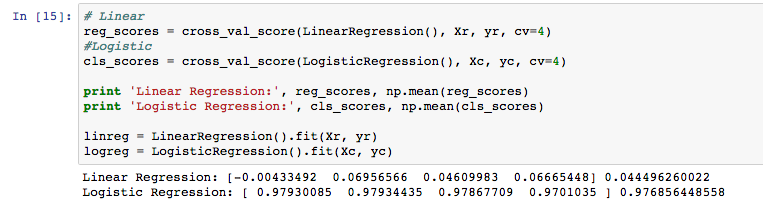

In [44]:
Image(filename='../../../../../Desktop/LinLogReg.png')

Interestingly, the linear regression automatically returns better (over 2x) than baseline (which was at 2.07%), of about 4.4%. So technically, I already know that my food groups are performing okay relative to baseline. The logistic regression, though, is clearly overfitting. Perhaps we need further investigation to see what's happening.

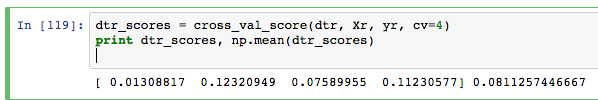

In [45]:
Image(filename='../../../../../Desktop/Screen Shot 2017-02-08 at 10.11.19 PM.png')

Well, I've been able to double my baseline - supposedly...

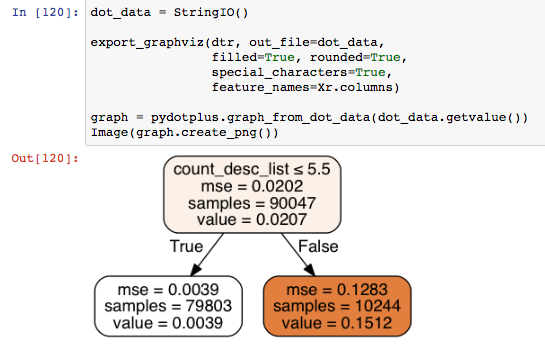

In [46]:
Image(filename='../../../../../Desktop/Screen Shot 2017-02-08 at 10.11.35 PM.png')

Unfortunately, I can attribute most of that to a relatively arbitrary number, and poor indicator for generalizing the model (the count of words used to describe the categories that a venue belongs to).

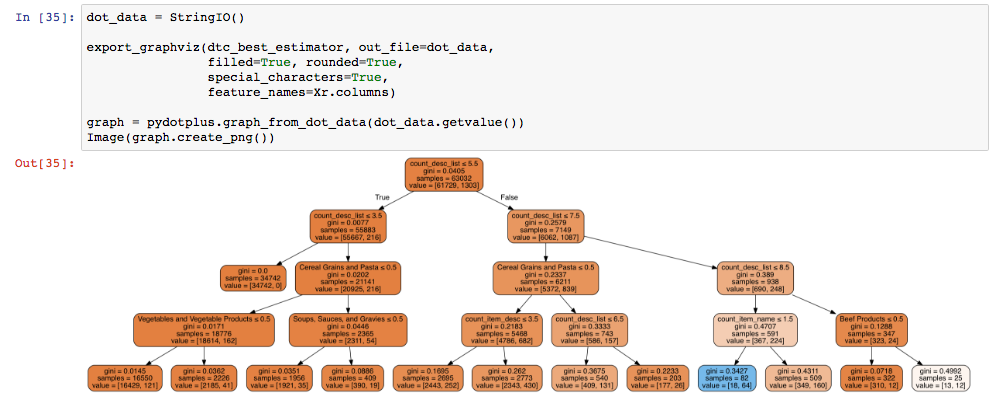

In [47]:
Image(filename='../../../../../Desktop/Screen Shot 2017-02-08 at 10.12.15 PM.png')

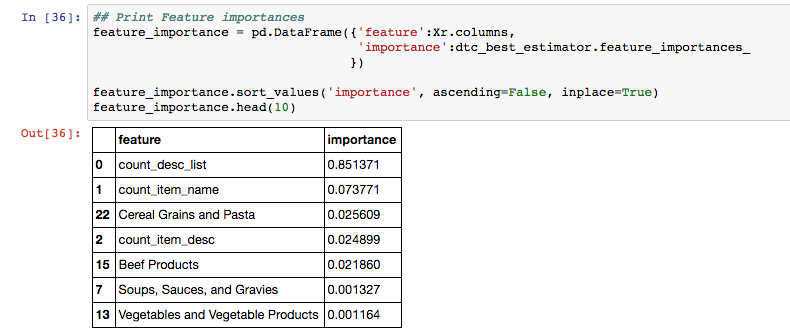

In [48]:
Image(filename='../../../../../Desktop/Screen Shot 2017-02-08 at 10.12.34 PM.png')

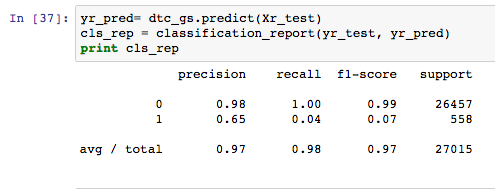

In [49]:
Image(filename='../../../../../Desktop/Screen Shot 2017-02-08 at 10.12.44 PM.png')

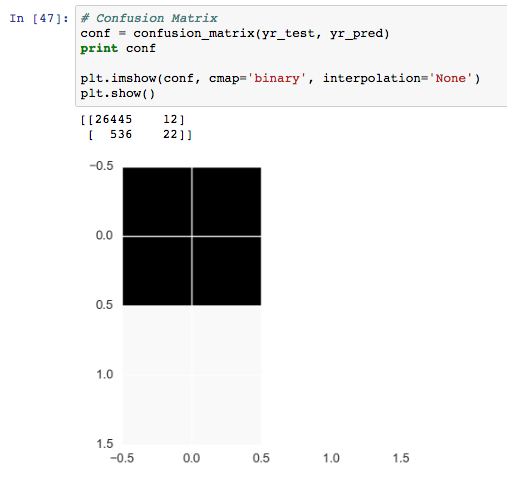

In [50]:
Image(filename='../../../../../Desktop/Screen Shot 2017-02-08 at 10.12.51 PM.png')

Well, even though I was able to get out a little more predictive power from my actual food groups, it is now abundantly clear that the decision trees were in fact using a few of my counter columns to account for most of the variance in the data between vegan and non-vegan items. Just to corroborate once again, I'll run a random forest model, which will provide more precise results than the decision trees.

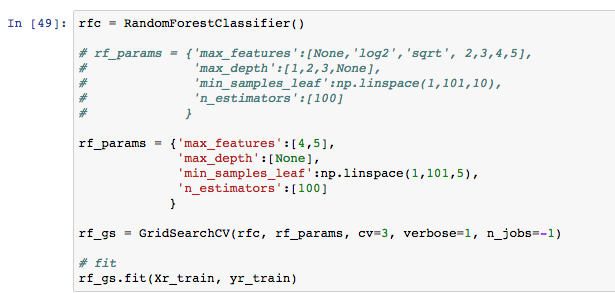

In [51]:
Image(filename='../../../../../Desktop/Screen Shot 2017-02-08 at 10.13.21 PM.png')

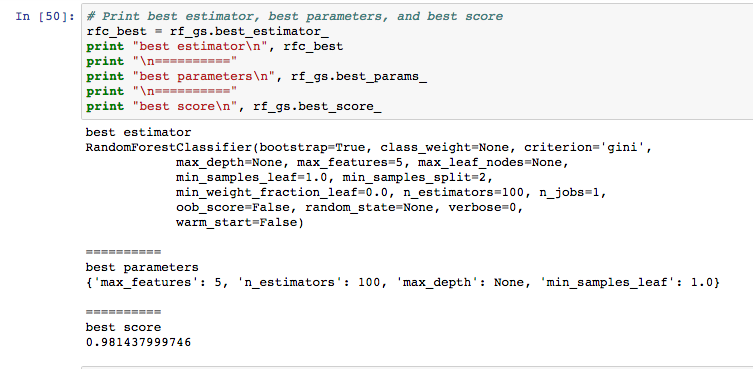

In [52]:
Image(filename='../../../../../Desktop/Screen Shot 2017-02-08 at 10.13.34 PM.png')

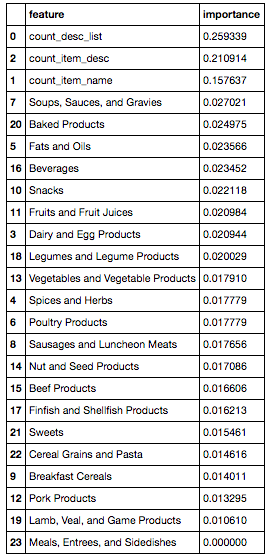

In [53]:
Image(filename='../../../../../Desktop/Screen Shot 2017-02-08 at 10.14.05 PM.png')

Again, we can see that the majority of the variance is in fact due to the arbitrary columns. I had originally kept them in the dataframe to serve as benchmarks for virtual noise - turns out they instead helped me determine that my groupings were not as effective as hoped. At least almost every food grouping accounted for 1-2% each, right? (admittedly not the greatest consolation prize...)

Below, I at least show a classification report that seems to have performed better than the previous trees. Precision indicates the percentage of items that were verifiably vegan out of all the items that I predicted to be vegan, while recall indicates the percentage of items that were correctly predicted to be vegan out of all the items that are actually vegan; f1-score yields a mixed proportion of the two.

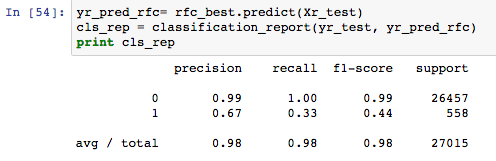

In [54]:
Image(filename='../../../../../Desktop/Screen Shot 2017-02-08 at 10.14.21 PM.png')

In the spirit of optimism, here's what a good ROC would look like. Perhaps one day I will be able to get there:

*ROC's, or Receiver Operating Curves are typically used to reflect the quality of binary classifiers. The y axis measures the true positive rate of the prediction, while the x axis measures the false positive rate (both on a scale of 0.0-1.0). A quality ROC is one that curves out above the baseline of the model, which appears generally as a dashed, diagonal line from the bottom left to the top right of the graph*

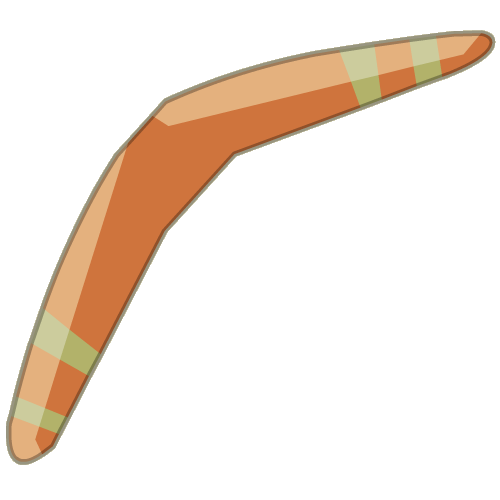

In [55]:
Image(filename='../../../../../Desktop/ROC.png')

When I cut out the arbitrary number columns, and redo the Random Forest model, I return a model that is even more  overfitted - yet another indicator that the groupings were not accurate. The classification report below also indicates that the random forest simply predicted every item to not be vegan, and scored well, because vegan items are anomalous to begin with.

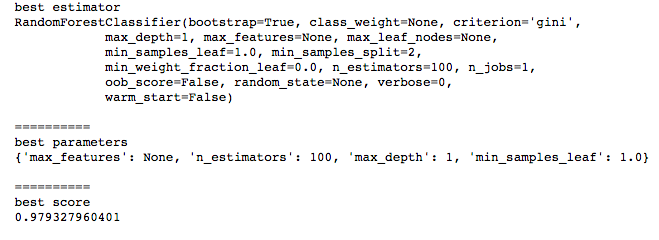

In [56]:
Image(filename='../../../../../Desktop/Screen Shot 2017-02-08 at 10.15.36 PM.png')

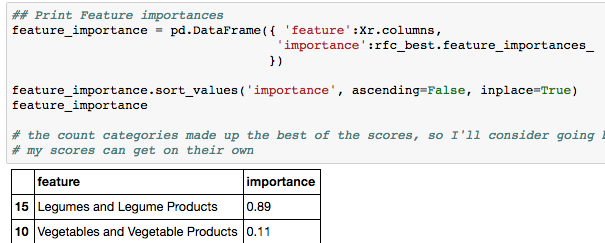

In [57]:
Image(filename='../../../../../Desktop/Screen Shot 2017-02-08 at 10.15.49 PM.png')

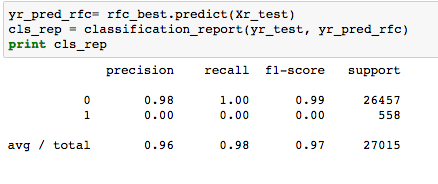

In [58]:
Image(filename='../../../../../Desktop/Screen Shot 2017-02-08 at 10.16.03 PM.png')

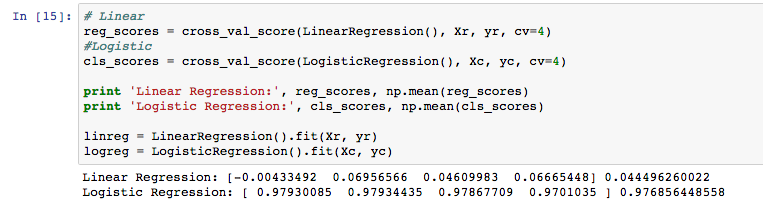

In [59]:
Image(filename='../../../../../Desktop/LinLogReg.png')

## Leveraging the  TFIDF vectorizer

__Menu item names__

Though I was less successful modeling my data, I was able to use TFIDF to gain some basic insights regarding particular features, such as menu item names, meta menus, and sub menus.

Below, I've shown that for the vegan and omni subsets, the top food groups are fairly similar, implying that my model would be well served by improving my group identification (custom vectorizing) process. The 'bad' indicates my first attempt at identifying groups with a more simplistic vectorizer; the 'good' indicates the vectorizer that applies as many groups as possible to every string.

    - 1.) For the omni subset, I primarily improved the 'Soups, Sauces, and Gravies' and 'Sausages and Luncheon Meats' groups, because they were receiving the bulk of tags. However, it looks like I continue to have a lot of tagging for the 'Legumes and Legumes Products' group. But looking at the most common bigrams from the un processed item names, we can see that the most surfaced omni goods are drinks that share common names.
    - 2.) For the vegan subset, I immediately noticed that, unlike the omni subset, popular n-grams are actually food references, not beverages. Then looking at the 'bad' and 'good' groupings, I noticed that there is more diversity of groupings in general than the omni counterpart. But, I also see how the 'bad' groupings actually shows more diverse results. This is because, with the 'bad' script, I had limited my custom vectorizer to only consider the top 3 food group matches. The 'good' script is really just surfacing more of the outlier foodgroups (which may be more common), in turn overshadowing other food groups that may be more popular. This occurs because TFIDF is looking at the notable groups, whereas my custom vectorizer just attempted to rank the best matches for possible food groups.

In [60]:
updated_food.meta_menu_fg = updated_food.meta_menu_fg.map(lambda x: '' if x == None else x)
updated_food.depth_menu_fg = updated_food.depth_menu_fg.map(lambda x: '' if x == None else x)
updated_food.item_fg = updated_food.item_fg.map(lambda x: '' if x == None else x)
updated_food.item_fg_renewed = updated_food.item_fg_renewed.map(lambda x: '' if x == None else x)

In [61]:
updated_vegan = updated_food[updated_food.vegan_venue_check == 1]

In [62]:
mm_o_summ = ' '.join(updated_food.meta_menu_n)
mm_fg_summ = ' '.join(updated_food.meta_menu_fg)
dm_o_summ = ' '.join(updated_food.depth_menus_n)
dm_fg_summ = ' '.join(updated_food.depth_menu_fg)
name_o_summ = ' '.join(updated_food.menu_item_name) 
name_fg_summ_bad = ' '.join(updated_food.item_fg)
name_fg_summ_good = ' '.join(updated_food.item_fg_renewed)
desc_o_summ = ' '.join(updated_food.menu_item_desc)

In [63]:
# for omni - 
vect = TfidfVectorizer(stop_words='english', ngram_range=(2,5))

ngrams_summaries = vect.build_analyzer()(name_o_summ)
Counter(ngrams_summaries).most_common(8)

[(u'napa valley', 814),
 (u'pinot noir', 650),
 (u'cabernet sauvignon', 455),
 (u'fried rice', 453),
 (u'sauvignon blanc', 352),
 (u'russian river', 306),
 (u'ice cream', 300),
 (u'valley california', 224)]

In [64]:
# for omni - 
vect = TfidfVectorizer(stop_words='english', ngram_range=(2,5))

ngrams_summaries = vect.build_analyzer()(name_fg_summ_bad)
Counter(ngrams_summaries).most_common(5)

[(u'soups sauces', 20433),
 (u'soups sauces gravies', 20433),
 (u'sauces gravies', 20433),
 (u'sausages luncheon', 16227),
 (u'sausages luncheon meats', 16227)]

In [65]:
# for omni - 
vect = TfidfVectorizer(stop_words='english', ngram_range=(2,5))

ngrams_summaries = vect.build_analyzer()(name_fg_summ_good)
Counter(ngrams_summaries).most_common(5)

[(u'baked products', 52311),
 (u'legumes legume products', 50625),
 (u'legumes legume', 50625),
 (u'legume products', 50625),
 (u'soups sauces', 49035)]

In [66]:
name_o_summ = ' '.join(updated_vegan.menu_item_name)
name_fg_summ_bad = ' '.join(updated_vegan.item_fg)
name_fg_summ_good = ' '.join(updated_vegan.item_fg_renewed)

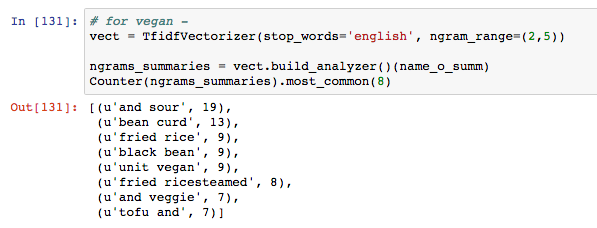

In [67]:
Image(filename='../../../../../Desktop/Screen Shot 2017-02-08 at 10.29.40 PM.png')

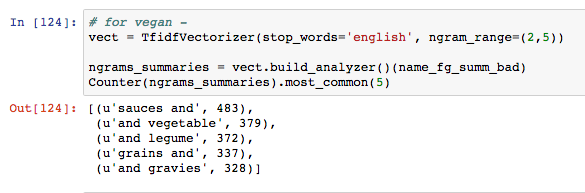

In [68]:
Image(filename='../../../../../Desktop/Screen Shot 2017-02-08 at 10.29.47 PM.png')

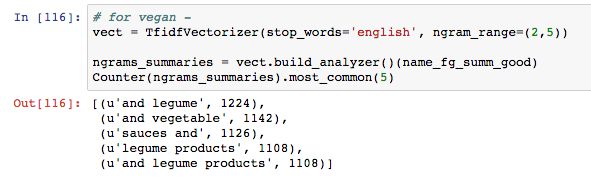

In [69]:
Image(filename='../../../../../Desktop/Screen Shot 2017-02-08 at 10.29.51 PM.png')

__MetaMenus__

The omni subset is basically signalling that my grouping vectorizer basically just batches anything that is 'main' as likely belonging to the 'Vegetables and Vegetables Products' group. This further shows some areas of improvement that I could make with batching strings into food groups. A similar pattern arises with my vegan subset, where anything that contains 'main' is batched into one of the more popular food groups for the vegan subset, namely the 'Legumes and Legumes Products.'

In [70]:
mm_o_summ = ' '.join(updated_food.meta_menu_n)
mm_fg_summ = ' '.join(updated_food.meta_menu_fg)
dm_o_summ = ' '.join(updated_food.depth_menus_n)
dm_fg_summ = ' '.join(updated_food.depth_menu_fg)

In [71]:
# for omni - 
vect = TfidfVectorizer(stop_words='english', ngram_range=(2,5))

ngrams_summaries = vect.build_analyzer()(mm_o_summ)
Counter(ngrams_summaries).most_common(8)

[(u'main menu', 30075),
 (u'menu main', 29988),
 (u'menu main menu', 29986),
 (u'main menu main', 29815),
 (u'main menu main menu', 29813),
 (u'menu main menu main', 29726),
 (u'menu main menu main menu', 29724),
 (u'main menu main menu main', 29553)]

In [72]:
# for omni - 
vect = TfidfVectorizer(stop_words='english', ngram_range=(2,5))

ngrams_summaries = vect.build_analyzer()(mm_fg_summ)
Counter(ngrams_summaries).most_common(5)

[(u'vegetable products', 35023),
 (u'vegetables vegetable products', 35023),
 (u'vegetables vegetable', 35023),
 (u'products vegetables vegetable', 33137),
 (u'products vegetables vegetable products', 33137)]

In [73]:
mm_o_summ = ' '.join(updated_vegan.meta_menu_n)
mm_fg_summ = ' '.join(updated_vegan.meta_menu_fg)

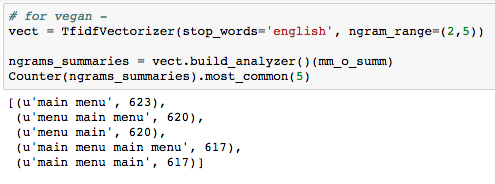

In [74]:
Image(filename='../../../../../Desktop/Screen Shot 2017-02-08 at 10.30.00 PM.png')

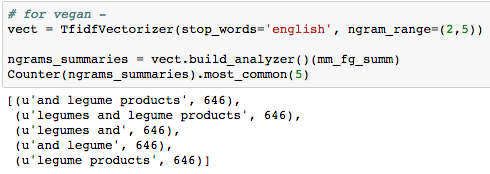

In [75]:
Image(filename='../../../../../Desktop/Screen Shot 2017-02-08 at 10.30.05 PM.png')

__SubMenus__

Running through the submenus to find n-grams reveals that the omni and vegan subsets are actually very similar as far as the groupings that resulted - namely that 'baked products' and 'legume products' surfaced commonly. However, while the omni submenus tend to use appetizer menus more frequently, vegan submenus tend to use 'special' fairly commonly, indicating that perhaps vegan restaurants are keen on highlighting how their options are differentiated.

In [76]:
dm_o_summ = ' '.join(updated_food.depth_menus_n)
dm_fg_summ = ' '.join(updated_food.depth_menu_fg)

In [77]:
# for omni - 
vect = TfidfVectorizer(stop_words='english', ngram_range=(2,5))

ngrams_summaries = vect.build_analyzer()(dm_o_summ)
Counter(ngrams_summaries).most_common(8)

[(u'appetizers appetizers', 2162),
 (u'appetizers appetizers appetizers', 1892),
 (u'appetizers appetizers appetizers appetizers', 1628),
 (u'main main', 1489),
 (u'sides sides', 1437),
 (u'salads salads', 1376),
 (u'appetizers appetizers appetizers appetizers appetizers', 1374),
 (u'main main main', 1363)]

In [78]:
# for omni - 
vect = TfidfVectorizer(stop_words='english', ngram_range=(2,5))

ngrams_summaries = vect.build_analyzer()(dm_fg_summ)
Counter(ngrams_summaries).most_common(8)

[(u'baked products', 36469),
 (u'legumes legume products', 34682),
 (u'legume products', 34682),
 (u'legumes legume', 34682),
 (u'soups sauces gravies', 30774),
 (u'soups sauces', 30774),
 (u'sauces gravies', 30774),
 (u'fats oils', 26434)]

In [79]:
dm_o_summ = ' '.join(updated_vegan.depth_menus_n)
dm_fg_summ = ' '.join(updated_vegan.depth_menu_fg)

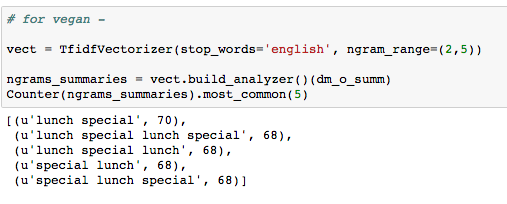

In [80]:
Image(filename='../../../../../Desktop/Screen Shot 2017-02-08 at 10.30.21 PM.png')

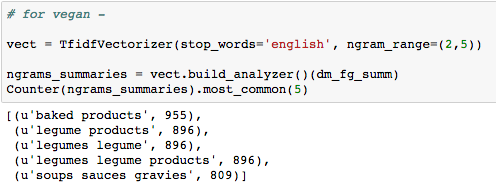

In [81]:
Image(filename='../../../../../Desktop/Screen Shot 2017-02-08 at 10.30.26 PM.png')

Laslty, I wanted to examine a relatively pertinent question for my project - how did the vectorizer label most of the menu items?

As it turns out, there were a few defining categories that can be surfaced when only considering the top 3 food groupings that the vectorizer assigns. For instance, Poultry, Cereal Grains and Pasta, Sweets, Fish, and Baked Products are all relatively well defined. Yet, it is also clear how groups like 'Soups Sauces and Gravies' and 'Sausages and Luncheon Meats' overlap frequently. Also problematically, we noticed how 'Vegetables and Vegetable Products' appears to come up often, when in fact this is more a reflection of the commonality of secondary vegetable ingredients in other food types.

In [82]:
food_set = updated_food[updated_food.item_fg != '']

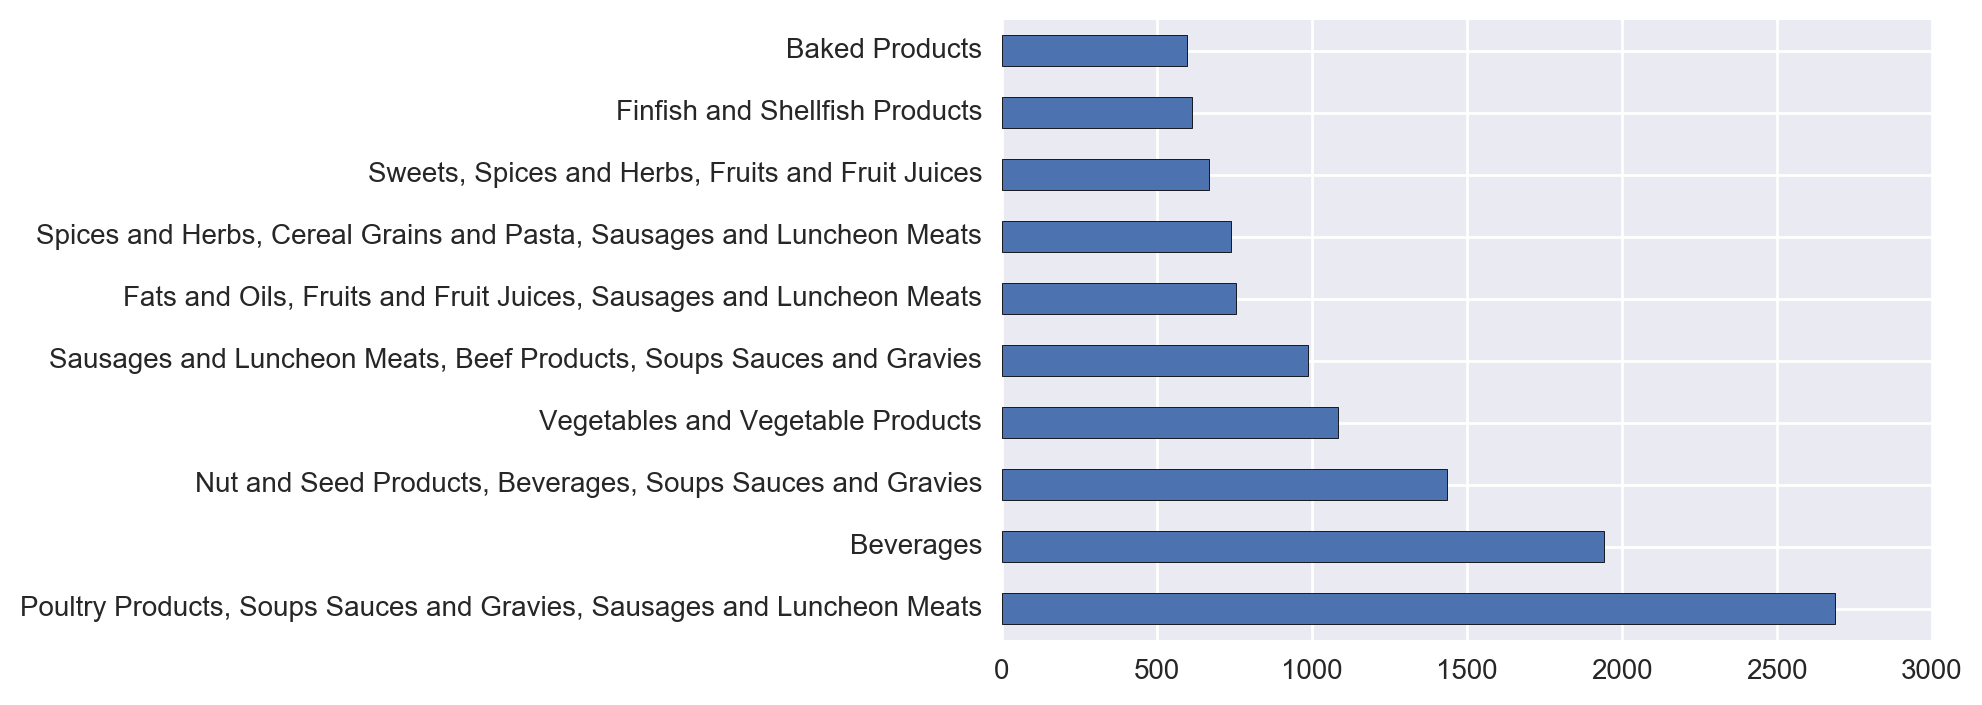

In [83]:
food_set.item_fg.value_counts().head(10).plot(kind='barh')

__Conclusions from Modeling Process__

As far as the lack of generalizeable success of my models, I am disappointed, but not completely surprised. I knew from the very beginning of this project that accurately picking out an anomaly would be challenging (the basline for vegan dishes is about 2%. This would be even more true considering that menus in general do not have as large a quantity of text as, say, more conventional texts like books (which are more common targets of NLP projects). However, I also strongly believe that my methodology was theoretically sound, and still stands a chance to show results, given further improvements in the technical approach. Specifically, my plan was to get menu information, compare it to broader food information, categorize the menu items into a smaller subset of groups, and finally, use those groups to ultimately make a prediction about how likely a product is to be vegan, or not. When I first came up with this plan, I was most concerned about the viability of organizing the menu data into a smaller subset of groups. I had hypothesized that the most difficult part would be to develop a tool that could read in food-related words, and output relevant groupings. While this indeed proved difficult and time-consuming, I was happy to see that as a widget, this tool was relatively accurate, particularly for the less-complex queries (keyword inputs). To digress, I believe this is actually the crux of my project, namely the lingual complexity hidden in simple menu items. But given that I had built the widget, my technical assumptions told me that the rest of the project would be relatively straight forward. It was only until I had spent a significant time modeling the processed data, having used a variety of models and preprocessing techniques, that I realized that in fact my assumptions were flawed. I had expected my models to perhaps yield an improvement of around 2x-4x my baseline (because it was so low, at 2%), but instead the data yielded an extremely over-fitted model, over and over again. After investigation, it slowly dawned on me that I would have had to perform more preprocessing on the source data itself, in other words, the menus. In part, I had gotten caught up in properly organizing my USDA information, so that I could merge it to the menus, and have it correspond intelligibly. In part, I was focused on creating a useful vectorizer to match the menu content to the USDA content. But I had assumed that by processing the menu data any further, I would significantly risk mis-representing the menu data for each venue. With the benefit of hindsight, I can say that I would like to further investigate ways to pre-process that menu content, while making sure to preserve the integrity of the original language. This is a fundamental factor in how well the end model would perform, so I would be excited to see how much of a difference it would make. Seeing as it is a significant bottle neck, I would be lightly optimistic. As far as a hypothetical approach, I would likely focus on accurately representing each menu item with as few words as possible. This would likely entail POS (part-of-speech) tagging, and n-gram analysis on the entire corpus of menu items, as well as a potentially extended stop-word list. The idea would be to leverage the quality of my vectorizing tool on assessing simpler food queries. 

# VII. Business Potential

From the outset, I envisioned making a consumer-facing product to address a specific, and personal problem: where can I buy my next vegan meal? Particularly given my background, the clearest way for me to productize this tool would be to develop a smartphone app similar to Yelp or Foursquare (a 'clone'). The defining feature, though, would be that instead of surfacing a number of venues, the app surfaces dishes that adhere to your personal dietary needs and desires. As far as the market landscape, there are perhaps two or three viable competitor apps currently available for download on the App Store. Both of these products essentially mimic all the functionality of Yelp and Foursquare, with the function of having a custom filter for vegan dishes. The problem though, is that these products are unable to surface a large number of dishes because they rely strictly on the quality of pre-existing data for tagged vegan venues. With a new product that leverages ML, I would hope to build a much more comprehensive tool, where one can index virtually any dish, and determine whether or not it is vegan (not just the venues that Yelp or Foursquare have already identified as vegan). An app would also allow me to enhance the quality of predictions over time. For example, I could ask the user to verify the predictions surfaced by the app (especially whether or not an item is vegan). This would both enhance the overall quality of the user experience of the app but also strengthen the behind-the-scenes data science work.

 # VIII. Future Potential

Though the scope of this project has been more or less addressed, I would certainly hope to make myriad improvements and optimizations. Below I have outlined a few personal priorities.

## A. Minimizing Overlap b/w Food Groups

I'd already briefly touched on improvements in how I could assign food words to particular food groups, but there are a number of other bottlenecks that would be interesting to address. In particular, I noticed one frustrating trend with some of the menu items that were already definitively identified as being vegan: my vectorizer had difficulty determining if a 'tofu sausage,' for instance, had pork, legumes, or both. This problem also arises with other modified ingredients like 'soy/almond/coconut milk,' 'vegan cheese' or 'almond butter.' A relatively simple solution would entail manually accounting for these specialty products in food group descriptions, by adding in these known problem cases. But, perhaps a more statistical or machine learning approach would use n-grams (of 2,3,4 words). By using n-grams, I could automate the process of surfacing vegan specialty products that riff off conventionally non-vegan goods. True, it would require significant EDA on both the vegan and omni subsets, but this improvement would leverage my previous work of having collected unique food groups. One of the core assumptions of the USDA data is that food groups have reasonably good separability amongst themselves, so it's key to cement that notion with better statistics.

It might also prove useful to add custom food groups that could batch ethnic foods. As was revealed through the EDA, a great deal of SF venues, and an even greater proportion of vegan venues, cook ethnic foods. The relatively obvious problem with indexing ethnic foods is that certain NLP techniques become less useful, for instance POS tagging, given the way different languages express similar concepts. Additionally, it becomes rather difficult to track what sort of dishes may use eggs, or have dairy products. So a potential solution would lie in creating a pair of food groups for specific ethnic categories, one vegan, and one omni. This would hopefully allow a model to also surface a variety of ethnic dishes, in addition to english-language dishes.

*Addendum: I noticed that the One vs Rest classifier helps when dealing with multilabeling issues, as those raised by my project. As I was not previously familiar with this tool, I partially recreated its functionality in my own vectorizer. However, knowing that this tool could model food groups to maximize their distinctiveness from one another makes me optimistic that I may be able to partially solve the bottlenecked problem of overlapping groups in the future. But of course, this will require further study.*

## B. Single-word to Multi-word Matching

For this project, I also focused on matching unique words to food groups. So even with the function that accepts several words as a parameter, my approach was to analyze each word independently. The driving logic behind that decision was that I would more frequently be able to assign a food group. But, this is best demonstrated by example. Suppose you have a 'burrito with salsa.' Well, particularly becuase I removed the Restaurant Foods group (which was the only one that kept track of burritos), a function that attempts to match several words in the input with all the descriptions that have those same set of words, and in that order, would yield no food group matches. However, 'salsa' by itself *can* be surfaced using my vectorizing functions. So instead of returning no food groups for an input like 'burrito with salsa,' I was at least able to say that a soup, sauce, or gravy was likely present in this food. Especially for the methodology used in this project, it was important to yield a critical mass of matched food groups. Having said that, it would be useful to independently score groups of words against descriptions in each food group, because I could potentially have a very highly correlated, and relevant food group to surface. I could again use a similar approach as before, by ranking the proportions that are outputted from the multi-word match and the single-word match.

## C. Product Decisions

In my closing points of discussion, I'll address some aspects that pertain more strictly to the business case I outlined and perhaps other supplemental use cases (or product features).

In addition to surfacing relevant food groups, for instance to service a pescetarian, vegan, or gluten-free user, I would be interested in exploring nutrient information for user-inputted food parameters. The USDA dataset, as discusesd previously, has comprehensive data at the ingredient-level for their 8,000 + indexed food items. With an increasingly accurate model to predict food groups, I would aspire to layer on a feature to estimate which ingredients may be present in given dishes. This would be particularly useful for users with allergies, or severe nutrient-based dietary restrictions - such as nuts, soy, and wheat (gluten). Though the predicted likelihood of ingredients in particular foods would be hard to independently corroborate, it may be possible to leverage user inputs. For instance, an app would be able to surface a prediction, along with an indicator like 'confirm that this item is vegan?' A positive response could reinforce the prediction, while a negative response could be used to filter out that prediction in the future.

If I were to go back to the beginning of this project, and modify my scraper, I could also pull location coordinates for particular venues. This would allow a product to filter out venues beyond a certain distance (say a couple miles), to only show relevant dishes within their vicinity. This would make the user experience more in-line with other production level, user-facing software.

It would also be interesting to create ever-more detailed widgets, such as ones that would allow a user to mask certain venue categories, or food groups, across mapped regions of SF. This would enable novel use cases, like observing where chinese food is concentrated in the city, or where vegan dishes exist in an area.

A product feature that would be feasible from my current datasets would relate to how dishes would be surfaced for a user. Becuase I have kept track of meta menus and sub menus, which often have titles like 'lunch' or 'breakfast and brunch' or 'dinner,' I'd be able to exclusively surface dishes that would be relevant at that particular day and time. Perhaps this would be yet another reason to grab more features with my scraper - to get closing and opening information.

It suffices to say that there are several business directions that could be pursued, and I hope that this reflects the quality of my approach in organizing and modeling this data: that it enables many more potential business cases.